# Librerias

In [1]:
#Se importan todas las librerias relevantes: torch, os, time, copy, random
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
import random
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn.functional as F

#Se ajusta una semilla para asegurar todos los resultados son iguales
torch.manual_seed(123)
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)
random.seed(123)

#Se comprueba la version de Python y PyTorch
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  2.0.1+cu118
Torchvision Version:  0.15.2+cu118


# Importamos dataset

In [2]:
# Definir transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((78, 78)), #Se asegura todas las imagenes tienen la misma forma con un ajuste de tamaño
    transforms.ToTensor(),  # Convertir a tensor de PyTorch
])



# Crear dataset personalizado de PyTorch
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.classes = ['Under', 'Over', 'Empty', 'OK']
        self.imgs = []
        
        for i, cls in enumerate(self.classes):
            cls_path = os.path.join(self.root_dir, cls)
            for img_name in os.listdir(cls_path):
                img_path = os.path.join(cls_path, img_name)
                self.imgs.append((img_path, i))  # Añadir ruta de imagen y su label
        
        # Mezclar las imágenes antes de dividir el dataset
        random.shuffle(self.imgs)
                
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img_path, label = self.imgs[idx]
        img = Image.open(img_path).convert('RGB')
        img = transform(img)
        return img, label

In [3]:
#Se traen los archivos de Drive donde están las imágenes
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/MyDrive/DatasetTFG/labeled')

In [4]:
# Crear el dataset personalizado apartir de la carpeta en drive
dataset = CustomDataset('/content/drive/MyDrive/DatasetTFG/labeled')

In [5]:
#Asegurar que trabajamos en la GPU
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


# Creamos dataset

In [ ]:
dataset_1 = torch.utils.data.Subset(dataset, range(10000)) # Se crea un dataset del tamaño deseado apartir del total

# Definir tamaño de los conjuntos de entrenamiento y validación (80%-20%)
train_size = int(0.8 * len(dataset_1))
val_size = len(dataset_1) - train_size

# Dividir el dataset en conjuntos de entrenamiento y validación de manera aleatoria
train_data, val_data = random_split(dataset_1, [train_size, val_size])

In [ ]:
# Creamos diccionario for training and validation
image_datasets = {'train': train_data, 'val': val_data}

# Creamos dataloaders for training and validation
batch_size = 8
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'val']}

# Comprobar dataset correcto

In [ ]:
# Imprimir el tamaño de los batches para los conjuntos de entrenamiento y validación
for phase in ['train', 'val']:
    dataloader = dataloaders_dict[phase]
    print(f'Tamaño de los batches para el conjunto de {phase}: {dataloader.batch_size}')
    print(f'Número de batches para el conjunto de {phase}: {len(dataloader)}')
    print(f'Número total de imágenes para el conjunto de {phase}: {len(dataloader.dataset)}')
    print('Clases:', dataset.classes)
    print()

Tamaño de los batches para el conjunto de train: 8
Número de batches para el conjunto de train: 10
Número total de imágenes para el conjunto de train: 80
Clases: ['Under', 'Over', 'Empty', 'OK']

Tamaño de los batches para el conjunto de val: 8
Número de batches para el conjunto de val: 3
Número total de imágenes para el conjunto de val: 20
Clases: ['Under', 'Over', 'Empty', 'OK']



In [ ]:
#Asegurar el dataset está equilibrado para todas las clases
dataloader = torch.utils.data.DataLoader(val_data, batch_size=64,
                                         shuffle=True, num_workers=1)


label_count = {'OK': 0, 'Under': 0, 'Empty': 0, 'Over': 0}

for _, labels in dataloader:
    for label in labels:
        label_str = ['OK', 'Under', 'Empty', 'Over'][label]
        label_count[label_str] += 1

print(label_count)

{'OK': 374, 'Under': 265, 'Empty': 74, 'Over': 287}


In [ ]:
# Obtener un batch de datos
images, labels = next(iter(dataloader))

# Visualizar las imágenes y etiquetas
fig, axs = plt.subplots(1, 20, figsize=(15, 3))
for i in range(20):
    axs[i].imshow(images[i].permute(1, 2, 0))
    axs[i].set_title(dataset.classes[labels[i]])
    axs[i].axis('off')
plt.show()

# Definir el modelo

In [6]:
# Elegimos el modelo [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "squeezenet"

# Numero de clases en el dataset
num_classes = 4

# Tamaño del Batch (cambiar segun el tamaño de la memoria)
batch_size = 8

# Numero de epocas por las que se entrena
num_epochs = 11

# Booleano para indicar si se hace feature extraction (true) o fine tunning (false)
#   cuando es true solo se cambian algunos parametros al final
feature_extract = False

In [7]:
#Se crea una clase para entrenar el modelo
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time() #Se comienza el cronometro

    #Se definen las variables para guardar los resultados del entrenamiento
    val_acc_history = []
    val_loss_history = []
    train_acc_history = []
    train_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    #Se crea un bucle para cada epoca
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Cada epoca tiene entrenamiento y validación
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # El modelo en entrenamiento
            else:
                model.eval()   # El modelo en validación

            #Se ajusta la perdida a 0 para cada epoca
            running_loss = 0.0
            running_corrects = 0

            # Dentro de cada epoca, se recorren los dataloaders.
            for inputs, labels in dataloaders[phase]:
                #Se envian los valores a la GPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # Solo si se esta en entrenamiento se hace el calculo de optimizacion y backpropagation
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Estadisticas
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc)) #Se imprimen las estadisticas de la epoca

            # Se copia el mejor mejor modelo y se crean los arrays con los valores de cada epoca
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)

        print()
   
    #Se imprimen los valores finales
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Se guardan los mejores valores y se devuelve la historia
    model.load_state_dict(best_model_wts)
    return model, val_acc_history,val_loss_history,train_acc_history,train_loss_history

In [8]:
#Se definen los parámetros a optimizar
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [9]:
#Se definen los diferentes modelos disponibles
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth
100%|██████████| 4.78M/4.78M [00:00<00:00, 173MB/s]

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [10]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 features.0.weight
	 features.0.bias
	 features.3.squeeze.weight
	 features.3.squeeze.bias
	 features.3.expand1x1.weight
	 features.3.expand1x1.bias
	 features.3.expand3x3.weight
	 features.3.expand3x3.bias
	 features.4.squeeze.weight
	 features.4.squeeze.bias
	 features.4.expand1x1.weight
	 features.4.expand1x1.bias
	 features.4.expand3x3.weight
	 features.4.expand3x3.bias
	 features.5.squeeze.weight
	 features.5.squeeze.bias
	 features.5.expand1x1.weight
	 features.5.expand1x1.bias
	 features.5.expand3x3.weight
	 features.5.expand3x3.bias
	 features.7.squeeze.weight
	 features.7.squeeze.bias
	 features.7.expand1x1.weight
	 features.7.expand1x1.bias
	 features.7.expand3x3.weight
	 features.7.expand3x3.bias
	 features.8.squeeze.weight
	 features.8.squeeze.bias
	 features.8.expand1x1.weight
	 features.8.expand1x1.bias
	 features.8.expand3x3.weight
	 features.8.expand3x3.bias
	 features.9.squeeze.weight
	 features.9.squeeze.bias
	 features.9.expand1x1.weight
	 features.

# Entrenamos el modelo y graficamos respuesta

In [ ]:
# Se elige el criterio del calculo de perdida
criterion = nn.CrossEntropyLoss()

# Se entrena el modelo
model_ft, hist_val_acc, hist_val_loss, hist_train_acc, hist_train_loss = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/4
----------
train Loss: 0.3431 Acc: 0.8750
val Loss: 0.9113 Acc: 0.7000

Epoch 1/4
----------
train Loss: 0.2114 Acc: 0.9125
val Loss: 1.2818 Acc: 0.7500

Epoch 2/4
----------
train Loss: 0.1706 Acc: 0.9375
val Loss: 1.3336 Acc: 0.7000

Epoch 3/4
----------
train Loss: 0.2582 Acc: 0.9250
val Loss: 1.1716 Acc: 0.6500

Epoch 4/4
----------
train Loss: 0.1240 Acc: 0.9750
val Loss: 1.5658 Acc: 0.7000

Training complete in 0m 4s
Best val Acc: 0.750000


In [ ]:
# Se entrena el modelo desde cero
scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_, scratch_hist_val_acc, scratch_hist_val_loss, scratch_hist_train_acc, scratch_hist_train_loss = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/10
----------


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


KeyboardInterrupt: ignored

Epoch 0/4
----------
train Loss: 1.3829 Acc: 0.2000
val Loss: 1.3978 Acc: 0.2000

Epoch 1/4
----------
train Loss: 1.3204 Acc: 0.3750
val Loss: 1.4318 Acc: 0.2000

Epoch 2/4
----------
train Loss: 1.2706 Acc: 0.3750
val Loss: 1.4811 Acc: 0.5000

Epoch 3/4
----------
train Loss: 1.2381 Acc: 0.4875
val Loss: 1.3837 Acc: 0.5000

Epoch 4/4
----------
train Loss: 1.1980 Acc: 0.5750
val Loss: 1.4063 Acc: 0.6000

Training complete in 0m 2s
Best val Acc: 0.600000


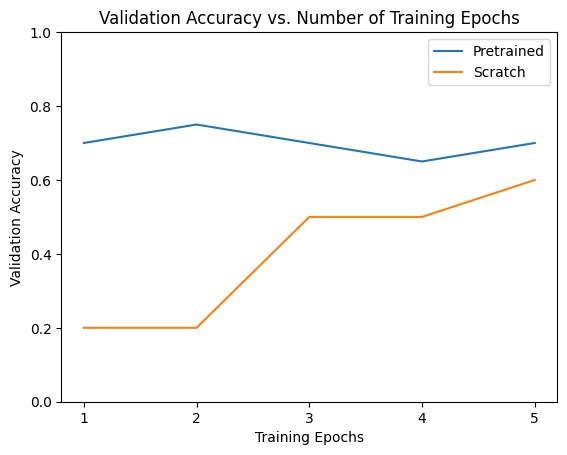

In [ ]:
# Se grafican los valores historicos de precisión de validacion en scratch y preentrenado
ohist_val_acc = []
shist_val_acc = []

ohist_val_acc = [h.cpu().numpy() for h in hist_val_acc]
shist_val_acc = [h.cpu().numpy() for h in scratch_hist_val_acc]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist_val_acc,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist_val_acc,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

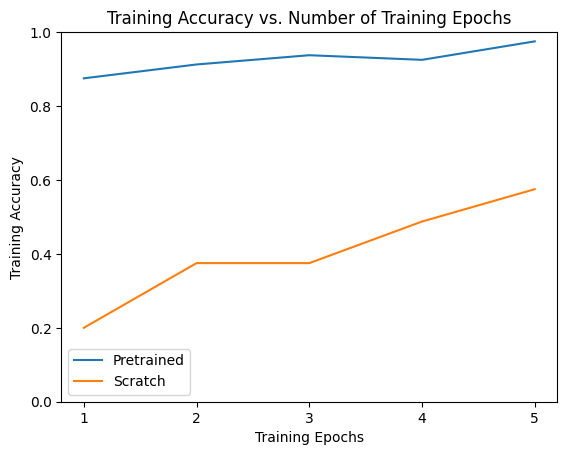

In [ ]:
# Se grafican los valores historicos de precisión de entranmiento en scratch y preentrenado
ohist_train_acc = []
shist_train_acc = []

ohist_train_acc = [h.cpu().numpy() for h in hist_train_acc]
shist_train_acc = [h.cpu().numpy() for h in scratch_hist_train_acc]

plt.title("Training Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Training Accuracy")
plt.plot(range(1,num_epochs+1),ohist_train_acc,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist_train_acc,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

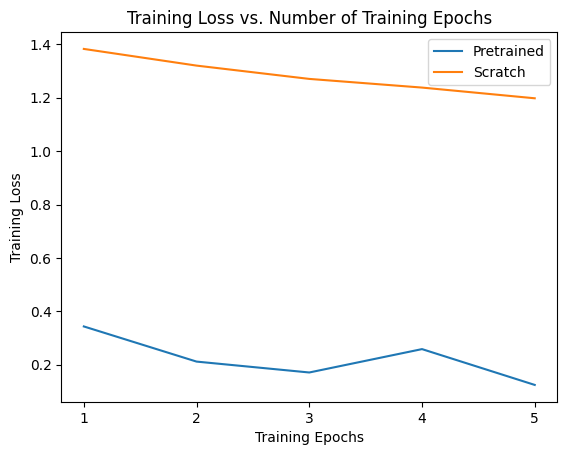

In [ ]:
# Se grafican los valores historicos de perdidas de entrenmiento en scratch y preentrenado
ohist_train_loss = []
shist_train_loss = []

ohist_train_loss = [h for h in hist_train_loss]
shist_train_loss = [h for h in scratch_hist_train_loss]

plt.title("Training Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Training Loss")
plt.plot(range(1,num_epochs+1),ohist_train_loss,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist_train_loss,label="Scratch")
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

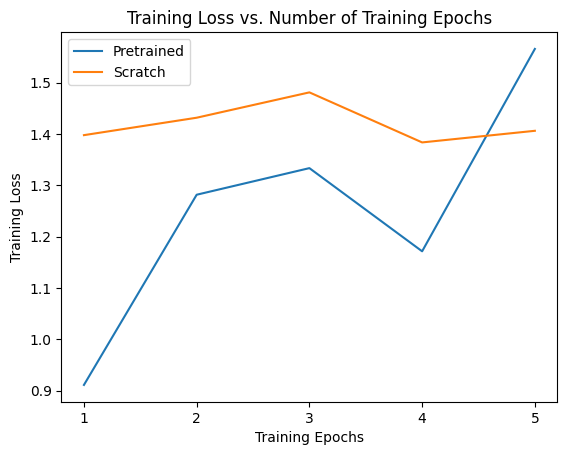

In [ ]:
# Se grafican los valores historicos de perdidas de validación en scratch y preentrenado
ohist_val_loss = []
shist_val_loss = []

ohist_val_loss = [h for h in hist_val_loss]
shist_val_loss = [h for h in scratch_hist_val_loss]

plt.title("Validation Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Loss")
plt.plot(range(1,num_epochs+1),ohist_val_loss,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist_val_loss,label="Scratch")
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

# Hacemos la grafica de matriz de confusion y grafica ROC

## Calculo de valores reales, supuestos y probabilidades para graficas

In [ ]:
#Se importan las librerias necesarias para las representaciones graficas complejas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay
from itertools import cycle

In [ ]:
#Se definen las clases del dataset
classes = ('Under', 'Over', 'Empty', 'OK')

In [ ]:
#En entas líneas de guardan los valores reales y supuestos del dataset y los resultados para las representaciones
y_pred_val = []
y_true_val = []
yscore_val = []

for inputs, labels in dataloaders_dict['val']: #validación o entrenamiento
        inputs, labels = inputs.to(device), labels.to(device)

        output = model_ft(inputs) # Feed Network
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred_val.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true_val.extend(labels) # Save Truth

        model_ft.eval()
        logits = model_ft(inputs)
        yscore = F.softmax(logits, dim=1).data.cpu().numpy() # assuming logits has the shape [batch_size, nb_classes]
        yscore_val.extend(yscore)

y_pred_val = np.array(y_pred_val)
y_true_val = np.array(y_true_val)
yscore_val = np.array(yscore_val)

In [ ]:
y_pred_train = []
y_true_train = []
yscore_train = []

for inputs, labels in dataloaders_dict['train']:
        inputs, labels = inputs.to(device), labels.to(device)

        output = model_ft(inputs) # Feed Network
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred_train.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true_train.extend(labels) # Save Truth

        model_ft.eval()
        logits = model_ft(inputs)
        yscore = F.softmax(logits, dim=1).data.cpu().numpy() # assuming logits has the shape [batch_size, nb_classes]
        yscore_train.extend(yscore)

y_pred_train = np.array(y_pred_train)
y_true_train = np.array(y_true_train)
yscore_train = np.array(yscore_train)

In [ ]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y_true_train)
y_onehot_test = label_binarizer.transform(y_true_val)
y_onehot_test.shape  # (n_samples, n_classes)

(1000, 4)

## Curva ROC

### Curva ROC se grafica una clase frente al resto

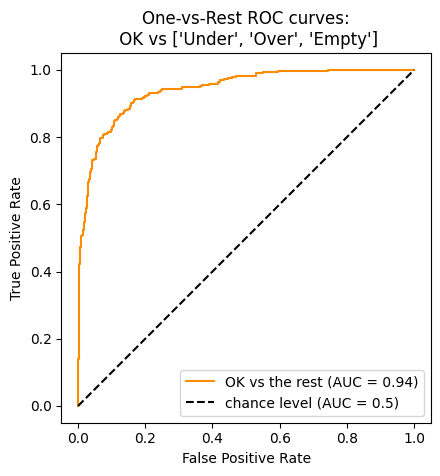

In [ ]:
#Elegir la clase que queremos ver frente al resto
classes = ('Under', 'Over', 'Empty', 'OK')
class_of_interest = 'OK'
class_id = classes.index(class_of_interest)
not_class_of_interest = [clase for clase in classes if clase != class_of_interest]

#Representamos la curva
RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    yscore_val[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"One-vs-Rest ROC curves:\n {class_of_interest} vs {not_class_of_interest}")
plt.legend()
plt.show()

### Curva ROC usando promedio micro

In [ ]:
print(f"y_score:\n{yscore_val[0:2,:]}")
print()
print(f"y_score.ravel():\n{yscore_val[0:2,:].ravel()}")

y_score:
[[0.03188204 0.9327026  0.00173881 0.03367653]
 [0.68334806 0.23844892 0.00231902 0.07588398]]

y_score.ravel():
[0.03188204 0.9327026  0.00173881 0.03367653 0.68334806 0.23844892
 0.00231902 0.07588398]


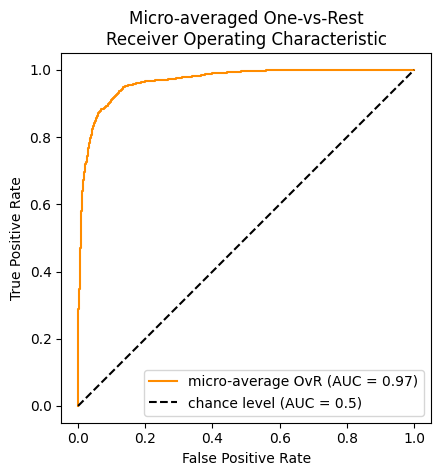

In [ ]:
RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    yscore_val.ravel(),
    name="micro-average OvR",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

micro_roc_auc_ovr = roc_auc_score(
    y_true_train,
    yscore_val,
    multi_class="ovr",
    average="micro",
)

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{micro_roc_auc_ovr:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.97


### Curva ROC mostrando todas las clases OvR calculado con premedio Macro

In [ ]:
macro_roc_auc_ovr = roc_auc_score(
    y_true_train,
    yscore_val,
    multi_class="ovr",
    average="macro",
)

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{macro_roc_auc_ovr:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.97


### Mostrar todas las curvas ROC OvR juntas

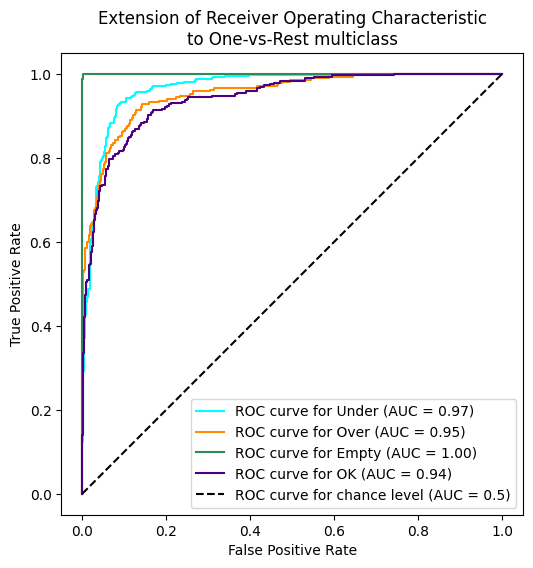

In [ ]:
from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))

colors = cycle(["aqua", "darkorange", "seagreen","indigo"])
for class_id, color in zip(range(len(classes)), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        yscore_val[:, class_id],
        name=f"ROC curve for {classes[class_id]}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()
plt.show()

### Se grafica la curva ROC para una contra una (OvO)

In [ ]:
class_dict = {0: 'Under', 1: 'Over', 2: 'Empty', 3: 'Ok'}
y_true_valnames = [(class_dict[label])
          for label in y_true_val
          if label in [0, 1, 2, 3]]

In [ ]:
from itertools import combinations


pair_list = list(combinations(np.unique(y_true_val), 2))
print(pair_list)

[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]


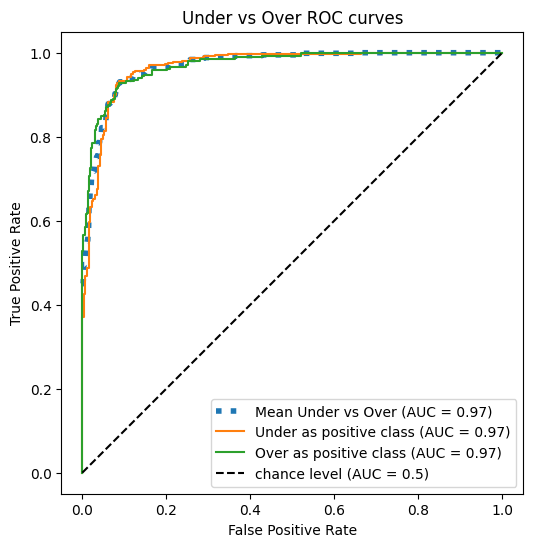

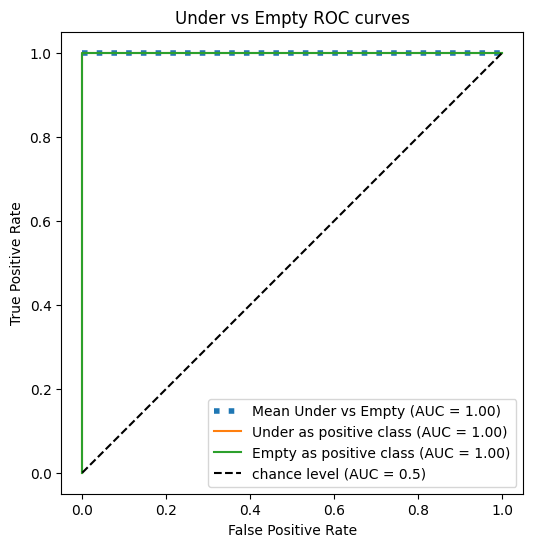

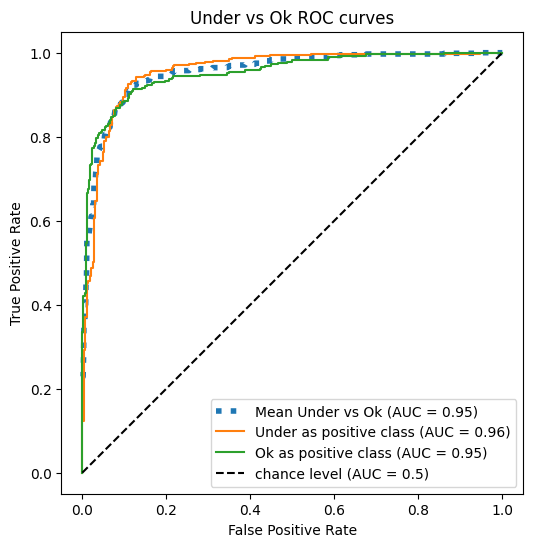

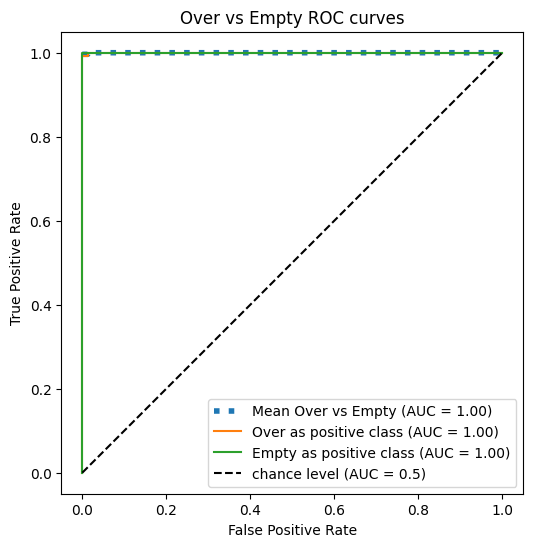

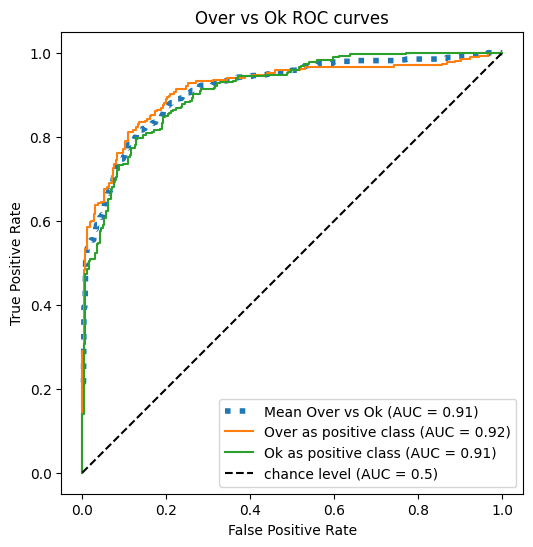

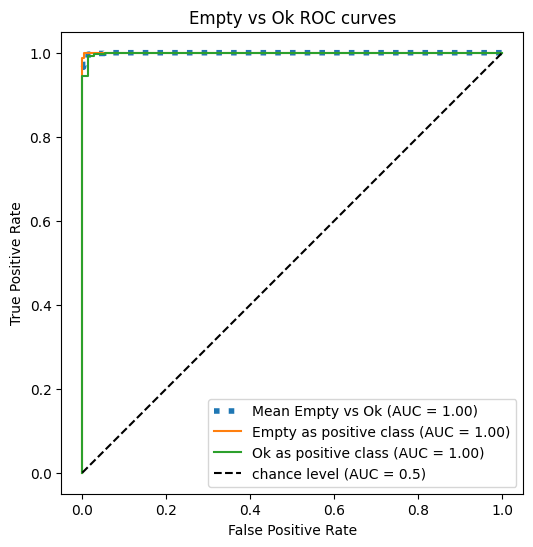

Macro-averaged One-vs-One ROC AUC score:
0.97


In [ ]:
from sklearn.metrics import roc_curve, auc

pair_scores = []
mean_tpr = dict()
fpr_grid = np.linspace(0.0, 1.0, 1000)

for ix, (label_a, label_b) in enumerate(pair_list):

    a_mask = y_true_val == label_a
    b_mask = y_true_val == label_b
    ab_mask = np.logical_or(a_mask, b_mask)

    a_true = a_mask[ab_mask]
    b_true = b_mask[ab_mask]

    idx_a = np.flatnonzero(label_binarizer.classes_ == label_a)[0]
    idx_b = np.flatnonzero(label_binarizer.classes_ == label_b)[0]

    fpr_a, tpr_a, _ = roc_curve(a_true, yscore_val[ab_mask, idx_a])
    fpr_b, tpr_b, _ = roc_curve(b_true, yscore_val[ab_mask, idx_b])

    mean_tpr[ix] = np.zeros_like(fpr_grid)
    mean_tpr[ix] += np.interp(fpr_grid, fpr_a, tpr_a)
    mean_tpr[ix] += np.interp(fpr_grid, fpr_b, tpr_b)
    mean_tpr[ix] /= 2
    mean_score = auc(fpr_grid, mean_tpr[ix])
    pair_scores.append(mean_score)

    fig, ax = plt.subplots(figsize=(6, 6))
    plt.plot(
        fpr_grid,
        mean_tpr[ix],
        label=f"Mean {class_dict[label_a]} vs {class_dict[label_b]} (AUC = {mean_score :.2f})",
        linestyle=":",
        linewidth=4,
    )
    RocCurveDisplay.from_predictions(
        a_true,
        yscore_val[ab_mask, idx_a],
        ax=ax,
        name=f"{class_dict[label_a]} as positive class",
    )
    RocCurveDisplay.from_predictions(
        b_true,
        yscore_val[ab_mask, idx_b],
        ax=ax,
        name=f"{class_dict[label_b]} as positive class",
    )
    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{classes[idx_a]} vs {class_dict[label_b]} ROC curves")
    plt.legend()
    plt.show()

print(f"Macro-averaged One-vs-One ROC AUC score:\n{np.average(pair_scores):.2f}")

In [ ]:
ovo_tpr = np.zeros_like(fpr_grid)

fig, ax = plt.subplots(figsize=(6, 6))
for ix, (label_a, label_b) in enumerate(pair_list):
    ovo_tpr += mean_tpr[ix]
    plt.plot(
        fpr_grid,
        mean_tpr[ix],
        label=f"Mean {label_a} vs {label_b} (AUC = {pair_scores[ix]:.2f})",
    )

ovo_tpr /= sum(1 for pair in enumerate(pair_list))

plt.plot(
    fpr_grid,
    ovo_tpr,
    label=f"One-vs-One macro-average (AUC = {macro_roc_auc_ovo:.2f})",
    linestyle=":",
    linewidth=4,
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-One multiclass")
plt.legend()
plt.show()

## Matriz de confusion

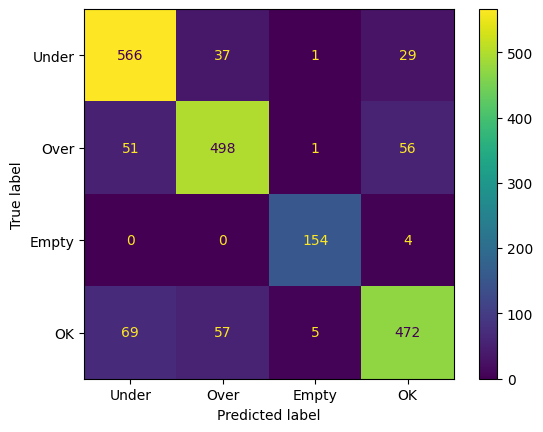

In [ ]:
# Mostrar matriz de confusion
cf_matrix = confusion_matrix(y_true_val, y_pred_val) #Validacion o entrenamiento
disp = ConfusionMatrixDisplay(confusion_matrix = cf_matrix, display_labels = classes)
disp.plot()
plt.show()

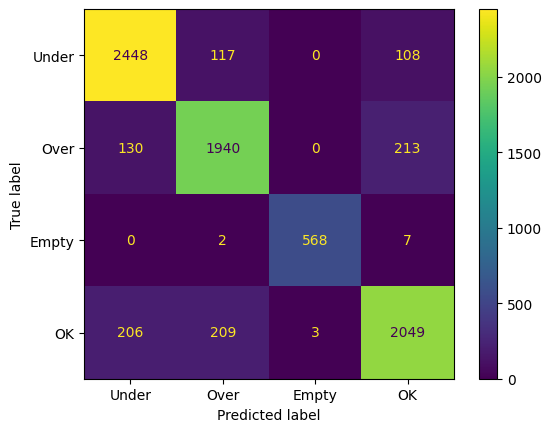

In [ ]:
# Build confusion matrix
cf_matrix = confusion_matrix(y_true_train, y_pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix = cf_matrix, display_labels = classes)
disp.plot()
plt.show()

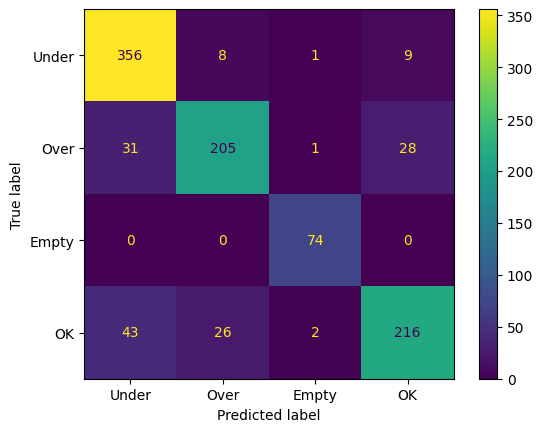

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in dataloaders_dict['val']:
        inputs, labels = inputs.to(device), labels.to(device)

        output = model_ft(inputs) # Feed Network
        #output = torch.max(output, 1)[1]
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('Under', 'Over', 'Empty', 'OK')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
#df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     #columns = [i for i in classes])
disp = ConfusionMatrixDisplay(confusion_matrix = cf_matrix, display_labels = classes)
disp.plot()
plt.show()

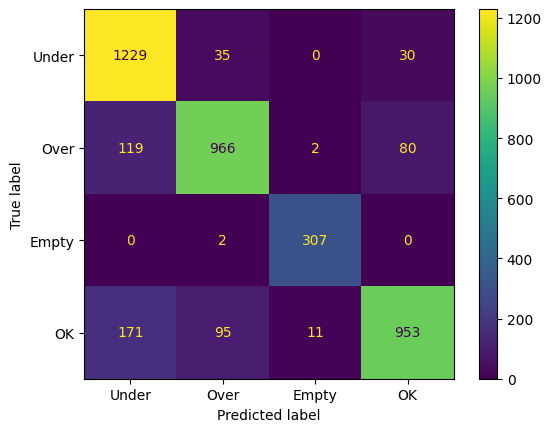

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in dataloaders_dict['train']:
        inputs, labels = inputs.to(device), labels.to(device)

        output = model_ft(inputs) # Feed Network
        #output = torch.max(output, 1)[1]
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('Under', 'Over', 'Empty', 'OK')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
#df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     #columns = [i for i in classes])
disp = ConfusionMatrixDisplay(confusion_matrix = cf_matrix, display_labels = classes)
disp.plot()
plt.show()
#plt.figure(figsize = (12,7))
#sn.heatmap(cf_matrix, annot=True)
#plt.savefig('output.png')

# Comparamos con diferentes tamaños del dataset: 100, 1000, 5000, 10000, 20000

## 100

In [ ]:
dataset_100 = torch.utils.data.Subset(dataset, range(100)) # Para un primer intento, dataset de 100 imagenes 

# Definir tamaño de los conjuntos de entrenamiento y validación
train_size = int(0.8 * len(dataset_100))
val_size = len(dataset_100) - train_size

# Dividir el dataset en conjuntos de entrenamiento y validación de manera aleatoria
train_data, val_data = random_split(dataset_100, [train_size, val_size])

In [ ]:
# Create datasets for training and validation
image_datasets = {'train': train_data, 'val': val_data}

# Create dataloaders for training and validation
batch_size = 8
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'val']}

In [ ]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist_val_acc, hist_val_loss, hist_train_acc, hist_train_loss = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/10
----------
train Loss: 1.4766 Acc: 0.3625
val Loss: 1.1770 Acc: 0.5500

Epoch 1/10
----------
train Loss: 1.1680 Acc: 0.6250
val Loss: 0.9075 Acc: 0.6500

Epoch 2/10
----------
train Loss: 0.8524 Acc: 0.6625
val Loss: 0.6912 Acc: 0.7000

Epoch 3/10
----------
train Loss: 1.0037 Acc: 0.6375
val Loss: 0.8413 Acc: 0.6500

Epoch 4/10
----------
train Loss: 1.0352 Acc: 0.5125
val Loss: 0.8089 Acc: 0.5500

Epoch 5/10
----------
train Loss: 0.7998 Acc: 0.7375
val Loss: 0.9541 Acc: 0.6500

Epoch 6/10
----------
train Loss: 0.6318 Acc: 0.7750
val Loss: 0.7625 Acc: 0.7000

Epoch 7/10
----------
train Loss: 0.4870 Acc: 0.8375
val Loss: 0.5682 Acc: 0.8000

Epoch 8/10
----------
train Loss: 0.3282 Acc: 0.8375
val Loss: 0.5559 Acc: 0.8000

Epoch 9/10
----------
train Loss: 0.2098 Acc: 0.9000
val Loss: 0.8965 Acc: 0.7500

Epoch 10/10
----------
train Loss: 0.1640 Acc: 0.9375
val Loss: 1.9301 Acc: 0.7000

Training complete in 0m 45s
Best val Acc: 0.800000


In [ ]:
# Initialize the non-pretrained version of the model used for this run
scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_, scratch_hist_val_acc, scratch_hist_val_loss, scratch_hist_train_acc, scratch_hist_train_loss = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/10
----------
train Loss: 1.3953 Acc: 0.2625
val Loss: 1.3766 Acc: 0.3000

Epoch 1/10
----------
train Loss: 1.3418 Acc: 0.3375
val Loss: 1.3460 Acc: 0.3000

Epoch 2/10
----------
train Loss: 1.2350 Acc: 0.4125
val Loss: 1.3993 Acc: 0.3500

Epoch 3/10
----------
train Loss: 1.2116 Acc: 0.4500
val Loss: 1.3580 Acc: 0.3000

Epoch 4/10
----------
train Loss: 1.2157 Acc: 0.3250
val Loss: 1.3247 Acc: 0.3500

Epoch 5/10
----------
train Loss: 1.1883 Acc: 0.4500
val Loss: 1.2990 Acc: 0.5000

Epoch 6/10
----------
train Loss: 1.1628 Acc: 0.5125
val Loss: 1.2682 Acc: 0.5500

Epoch 7/10
----------
train Loss: 1.1547 Acc: 0.4750
val Loss: 1.2729 Acc: 0.4000

Epoch 8/10
----------
train Loss: 1.1008 Acc: 0.6000
val Loss: 1.1460 Acc: 0.6000

Epoch 9/10
----------
train Loss: 1.0534 Acc: 0.6000
val Loss: 1.1217 Acc: 0.5000

Epoch 10/10
----------
train Loss: 1.0706 Acc: 0.5625
val Loss: 1.0992 Acc: 0.5000

Training complete in 0m 53s
Best val Acc: 0.600000


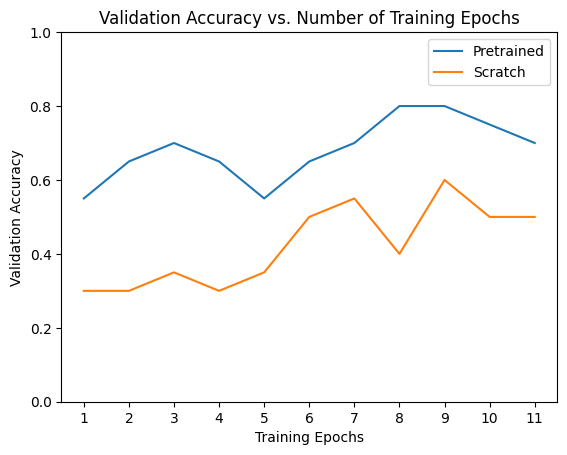

In [13]:
# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch

ohist_val_acc = [0.5500, 0.6500, 0.7000, 0.6500, 0.5500, 0.6500, 0.7000, 0.8000, 0.8000, 0.7500, 0.7000]
shist_val_acc = [0.3000, 0.3000, 0.3500, 0.3000, 0.3500, 0.5000, 0.5500, 0.4000, 0.6000, 0.5000, 0.5000]
ohist_train_acc = [0.3625, 0.6250, 0.6625, 0.6375, 0.5125, 0.7375, 0.7750, 0.8375, 0.8375, 0.9000, 0.9375]
shist_train_acc = [0.2625, 0.3375, 0.4125, 0.4500, 0.3250, 0.4500, 0.5125, 0.4750, 0.6000, 0.6000, 0.5625]
ohist_val_loss = [1.1770, 0.9075, 0.6912, 0.8413, 0.8089, 0.9541, 0.7625, 0.5682, 0.5559, 0.8965, 1.9301]
shist_val_loss = [1.3766, 1.3460, 1.3993, 1.3580, 1.3247, 1.2990, 1.2682, 1.2729, 1.1460, 1.1217, 1.0992]
ohist_train_loss = [1.4766, 1.1680, 0.8524, 1.0037, 1.0352, 0.7998, 0.6318, 0.4870, 0.3282, 0.2098, 0.1640]
shist_train_loss = [1.3953, 1.3418, 1.2350, 1.2116, 1.2157, 1.1883, 1.1628, 1.1547, 1.1008, 1.0534, 1.0706]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist_val_acc,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist_val_acc,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

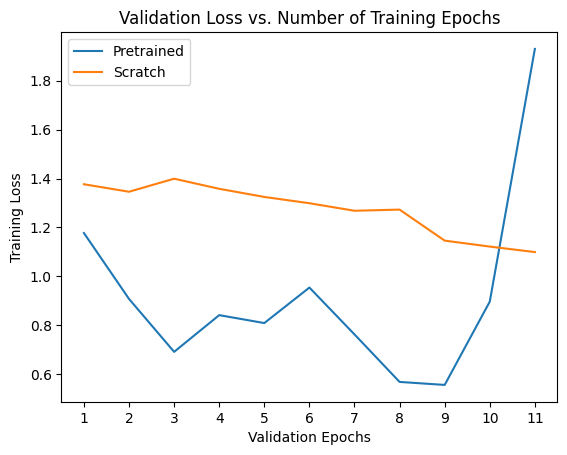

In [14]:
plt.title("Validation Loss vs. Number of Training Epochs")
plt.xlabel("Validation Epochs")
plt.ylabel("Training Loss")
plt.plot(range(1,num_epochs+1),ohist_val_loss,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist_val_loss,label="Scratch")
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

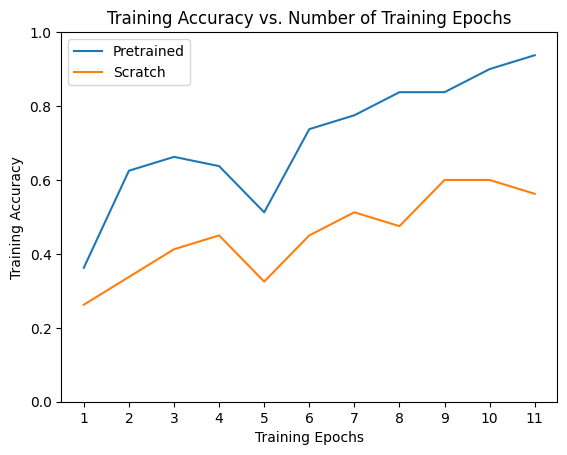

In [15]:
plt.title("Training Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Training Accuracy")
plt.plot(range(1,num_epochs+1),ohist_train_acc,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist_train_acc,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

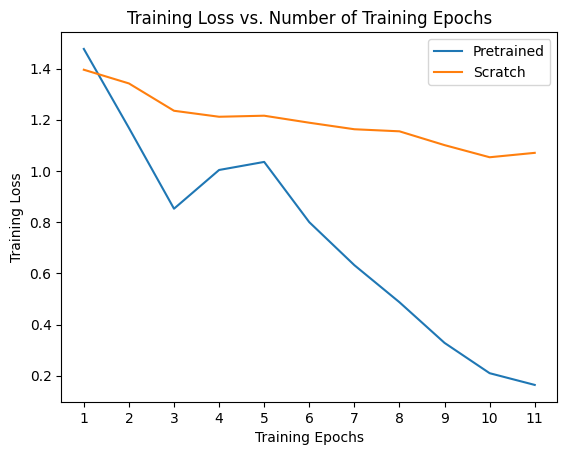

In [16]:
plt.title("Training Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Training Loss")
plt.plot(range(1,num_epochs+1),ohist_train_loss,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist_train_loss,label="Scratch")
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

## 1000

In [ ]:
dataset_1000 = torch.utils.data.Subset(dataset, range(1000)) # Dividimos el dataset en 1000 imagenes

# Definir tamaño de los conjuntos de entrenamiento y validación (Un 20% de las imágenes para la validación)
train_size = int(0.8 * len(dataset_1000))
val_size = len(dataset_1000) - train_size

# Dividir el dataset en conjuntos de entrenamiento y validación de manera aleatoria
train_data, val_data = random_split(dataset_1000, [train_size, val_size])

In [ ]:
# Creamos un diccionario con los datasets de entrenamiento y validación
image_datasets = {'train': train_data, 'val': val_data}

# Creamos un diccionario con los dataloaders del diccionario image_datasets
batch_size = 8
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'val']}

In [ ]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist_val_acc, hist_val_loss, hist_train_acc, hist_train_loss = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/10
----------
train Loss: 1.1435 Acc: 0.5325
val Loss: 0.8099 Acc: 0.6850

Epoch 1/10
----------
train Loss: 0.7521 Acc: 0.7362
val Loss: 0.5656 Acc: 0.7750

Epoch 2/10
----------
train Loss: 0.6135 Acc: 0.7812
val Loss: 0.5218 Acc: 0.8400

Epoch 3/10
----------
train Loss: 0.5978 Acc: 0.7712
val Loss: 0.6996 Acc: 0.7300

Epoch 4/10
----------
train Loss: 0.5189 Acc: 0.8063
val Loss: 0.4667 Acc: 0.8250

Epoch 5/10
----------
train Loss: 0.4728 Acc: 0.8113
val Loss: 0.4792 Acc: 0.8550

Epoch 6/10
----------
train Loss: 0.4168 Acc: 0.8375
val Loss: 0.4816 Acc: 0.8650

Epoch 7/10
----------
train Loss: 0.3745 Acc: 0.8638
val Loss: 0.5081 Acc: 0.8700

Epoch 8/10
----------
train Loss: 0.4161 Acc: 0.8387
val Loss: 0.4463 Acc: 0.8300

Epoch 9/10
----------
train Loss: 0.3172 Acc: 0.8700
val Loss: 0.4874 Acc: 0.8100

Epoch 10/10
----------
train Loss: 0.2872 Acc: 0.8912
val Loss: 0.4700 Acc: 0.8400

Training complete in 2m 28s
Best val Acc: 0.870000


In [ ]:
# Initialize the non-pretrained version of the model used for this run
scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_, scratch_hist_val_acc, scratch_hist_val_loss, scratch_hist_train_acc, scratch_hist_train_loss = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/10
----------


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


train Loss: 1.2669 Acc: 0.3488
val Loss: 1.1849 Acc: 0.3750

Epoch 1/10
----------
train Loss: 0.9580 Acc: 0.5763
val Loss: 0.6231 Acc: 0.7300

Epoch 2/10
----------
train Loss: 0.7838 Acc: 0.6837
val Loss: 0.9142 Acc: 0.5900

Epoch 3/10
----------
train Loss: 0.7416 Acc: 0.7512
val Loss: 0.7471 Acc: 0.8050

Epoch 4/10
----------
train Loss: 0.6499 Acc: 0.7963
val Loss: 0.6753 Acc: 0.7300

Epoch 5/10
----------
train Loss: 0.5924 Acc: 0.7950
val Loss: 0.4686 Acc: 0.8550

Epoch 6/10
----------
train Loss: 0.5728 Acc: 0.7975
val Loss: 0.4879 Acc: 0.7950

Epoch 7/10
----------
train Loss: 0.5780 Acc: 0.8113
val Loss: 0.4484 Acc: 0.8350

Epoch 8/10
----------
train Loss: 0.5328 Acc: 0.8025
val Loss: 0.4307 Acc: 0.8200

Epoch 9/10
----------
train Loss: 0.5940 Acc: 0.7825
val Loss: 0.4216 Acc: 0.8450

Epoch 10/10
----------
train Loss: 0.5334 Acc: 0.7988
val Loss: 0.6011 Acc: 0.7950

Training complete in 3m 34s
Best val Acc: 0.855000


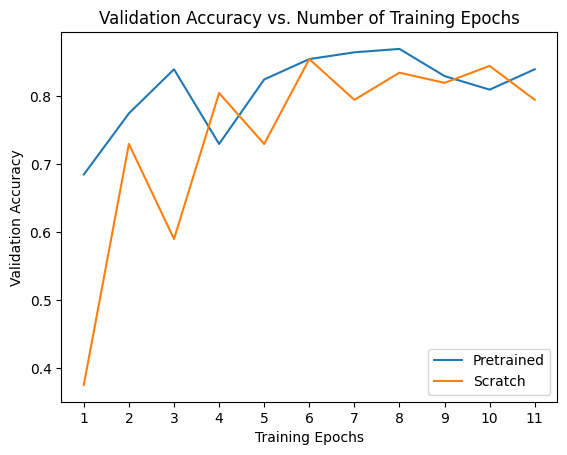

In [17]:
ohist_val_acc = [0.6850, 0.7750, 0.8400, 0.7300, 0.8250, 0.8550, 0.8650, 0.8700, 0.8300, 0.8100, 0.8400]
shist_val_acc = [0.3750, 0.7300, 0.5900, 0.8050, 0.7300, 0.8550, 0.7950, 0.8350, 0.8200, 0.8450, 0.7950]
ohist_train_acc = [0.5325, 0.7362, 0.7812, 0.7712, 0.8063, 0.8113, 0.8375, 0.8638, 0.8387, 0.8700, 0.8912]
shist_train_acc = [0.3488, 0.5763, 0.6837, 0.7512, 0.7963, 0.7950, 0.7975, 0.8113, 0.8025, 0.7825, 0.7988]
ohist_val_loss = [0.8099, 0.5656, 0.5218, 0.6996, 0.4667, 0.4792, 0.4816, 0.5081, 0.4463, 0.4874, 0.4700]
shist_val_loss = [1.1849, 0.6231, 0.9142, 0.7471, 0.6753, 0.4686, 0.4879, 0.4484, 0.4307, 0.4216, 0.6011]
ohist_train_loss = [1.1435, 0.7521, 0.6135, 0.5978, 0.5189, 0.4728, 0.4168, 0.3745, 0.4161, 0.3172, 0.2872]
shist_train_loss = [1.2669, 0.9580, 0.7838, 0.7416, 0.6499, 0.5924, 0.5728, 0.5780, 0.5328, 0.5940, 0.5334]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist_val_acc,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist_val_acc,label="Scratch")
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

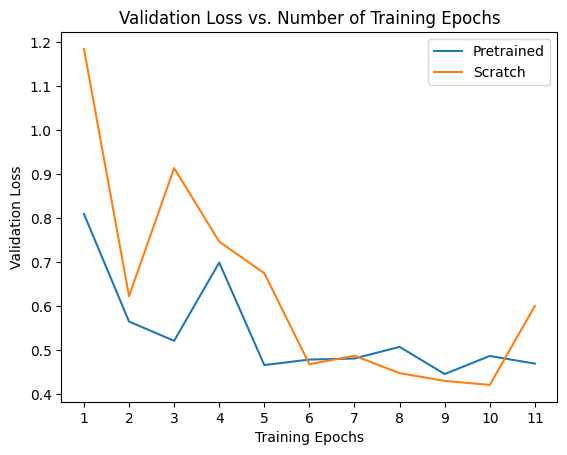

In [18]:
plt.title("Validation Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Loss")
plt.plot(range(1,num_epochs+1),ohist_val_loss,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist_val_loss,label="Scratch")
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

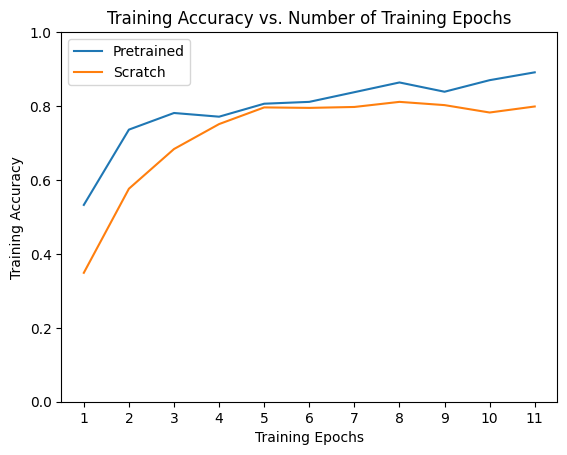

In [19]:
plt.title("Training Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Training Accuracy")
plt.plot(range(1,num_epochs+1),ohist_train_acc,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist_train_acc,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

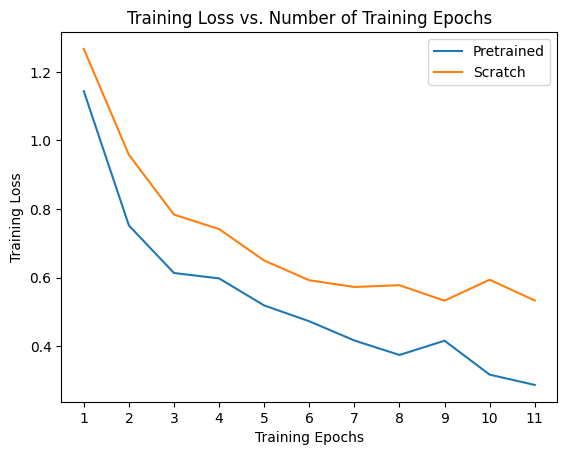

In [20]:
plt.title("Training Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Training Loss")
plt.plot(range(1,num_epochs+1),ohist_train_loss,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist_train_loss,label="Scratch")
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

## 5000

In [ ]:
dataset_5000 = torch.utils.data.Subset(dataset, range(5000)) # Para un primer intento, dataset de 100 imagenes 

# Definir tamaño de los conjuntos de entrenamiento y validación
train_size = int(0.8 * len(dataset_5000))
val_size = len(dataset_5000) - train_size

# Dividir el dataset en conjuntos de entrenamiento y validación de manera aleatoria
train_data, val_data = random_split(dataset_5000, [train_size, val_size])

In [ ]:
# Creamos un diccionario con los datasets de entrenamiento y validación
image_datasets = {'train': train_data, 'val': val_data}

# Creamos un diccionario con los dataloaders del diccionario image_datasets
batch_size = 8
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'val']}

In [ ]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist_val_acc, hist_val_loss, hist_train_acc, hist_train_loss = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/10
----------
train Loss: 0.7660 Acc: 0.7225
val Loss: 0.5530 Acc: 0.7850

Epoch 1/10
----------
train Loss: 0.5165 Acc: 0.8063
val Loss: 0.5697 Acc: 0.7720

Epoch 2/10
----------
train Loss: 0.4475 Acc: 0.8315
val Loss: 0.4415 Acc: 0.8300

Epoch 3/10
----------
train Loss: 0.4193 Acc: 0.8397
val Loss: 0.4494 Acc: 0.8240

Epoch 4/10
----------
train Loss: 0.4007 Acc: 0.8503
val Loss: 0.4624 Acc: 0.8360

Epoch 5/10
----------
train Loss: 0.3777 Acc: 0.8613
val Loss: 0.4957 Acc: 0.8250

Epoch 6/10
----------
train Loss: 0.3473 Acc: 0.8685
val Loss: 0.4783 Acc: 0.8310

Epoch 7/10
----------
train Loss: 0.3301 Acc: 0.8702
val Loss: 0.4660 Acc: 0.8380

Epoch 8/10
----------
train Loss: 0.3210 Acc: 0.8760
val Loss: 0.5392 Acc: 0.8130

Epoch 9/10
----------
train Loss: 0.2999 Acc: 0.8830
val Loss: 0.4678 Acc: 0.8280

Epoch 10/10
----------
train Loss: 0.2749 Acc: 0.8958
val Loss: 0.5048 Acc: 0.8380

Training complete in 11m 14s
Best val Acc: 0.838000


In [ ]:
# Initialize the non-pretrained version of the model used for this run
scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_, scratch_hist_val_acc, scratch_hist_val_loss, scratch_hist_train_acc, scratch_hist_train_loss = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/10
----------


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


train Loss: 0.8786 Acc: 0.6092
val Loss: 0.6513 Acc: 0.7230

Epoch 1/10
----------
train Loss: 0.6557 Acc: 0.7283
val Loss: 0.6193 Acc: 0.7530

Epoch 2/10
----------
train Loss: 0.6343 Acc: 0.7362
val Loss: 0.6344 Acc: 0.7650

Epoch 3/10
----------
train Loss: 0.6068 Acc: 0.7350
val Loss: 0.5873 Acc: 0.7680

Epoch 4/10
----------
train Loss: 0.5785 Acc: 0.7445
val Loss: 0.5897 Acc: 0.7470

Epoch 5/10
----------
train Loss: 0.5719 Acc: 0.7492
val Loss: 0.5827 Acc: 0.7510

Epoch 6/10
----------
train Loss: 0.5590 Acc: 0.7572
val Loss: 0.6133 Acc: 0.7550

Epoch 7/10
----------
train Loss: 0.5459 Acc: 0.7618
val Loss: 0.5926 Acc: 0.7550

Epoch 8/10
----------
train Loss: 0.5386 Acc: 0.7590
val Loss: 0.6110 Acc: 0.7470

Epoch 9/10
----------
train Loss: 0.5407 Acc: 0.7578
val Loss: 0.5315 Acc: 0.7680

Epoch 10/10
----------
train Loss: 0.5290 Acc: 0.7630
val Loss: 0.5349 Acc: 0.7580

Training complete in 11m 3s
Best val Acc: 0.768000


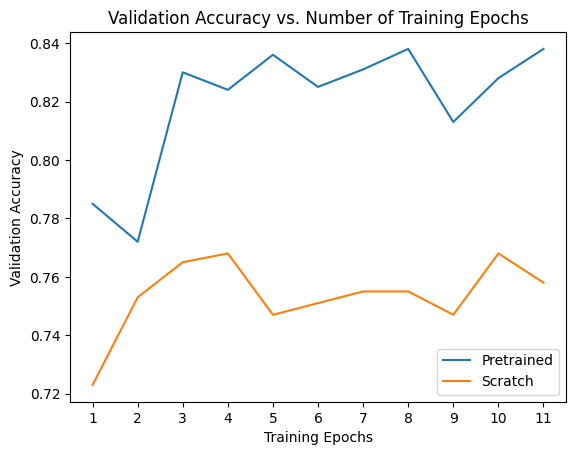

In [21]:
ohist_val_acc = [0.7850, 0.7720, 0.8300, 0.8240, 0.8360, 0.8250, 0.8310, 0.8380, 0.8130, 0.8280, 0.8380]
shist_val_acc = [0.7230, 0.7530, 0.7650, 0.7680, 0.7470, 0.7510, 0.7550, 0.7550, 0.7470, 0.7680, 0.7580]
ohist_train_acc = [0.7225, 0.8063, 0.8315, 0.8397, 0.8503, 0.8613, 0.8685, 0.8702, 0.8760, 0.8830, 0.8958]
shist_train_acc = [0.6092, 0.7283, 0.7362, 0.7350, 0.7445, 0.7492, 0.7572, 0.7618, 0.7590, 0.7578, 0.7630]
ohist_val_loss = [0.5530, 0.5165, 0.4415, 0.4494, 0.4624, 0.4957, 0.4783, 0.4660, 0.5392, 0.4678, 0.5048]
shist_val_loss = [0.6513, 0.6193, 0.6344, 0.5873, 0.5897, 0.5827, 0.6133, 0.5926, 0.6110, 0.5315, 0.5349]
ohist_train_loss = [0.7660, 0.5165, 0.4475, 0.4193, 0.4007, 0.3777, 0.3473, 0.3301, 0.3210, 0.2999, 0.2749]
shist_train_loss = [0.8786, 0.6557, 0.6343, 0.6068, 0.5785, 0.5719, 0.5590, 0.5459, 0.5386, 0.5407, 0.5290]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist_val_acc,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist_val_acc,label="Scratch")
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

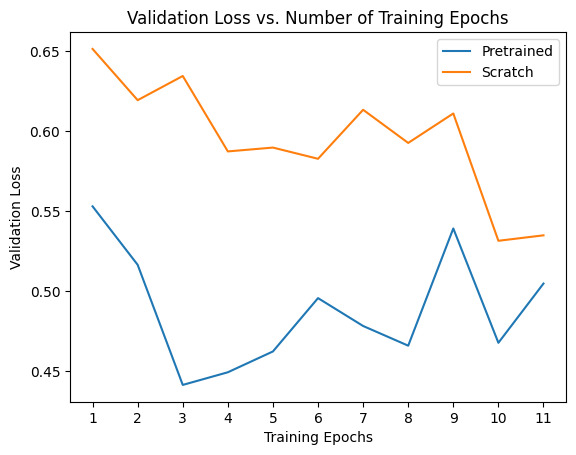

In [22]:
plt.title("Validation Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Loss")
plt.plot(range(1,num_epochs+1),ohist_val_loss,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist_val_loss,label="Scratch")
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

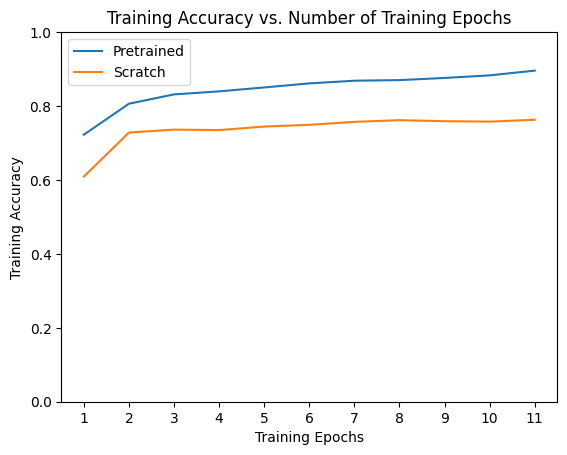

In [23]:
plt.title("Training Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Training Accuracy")
plt.plot(range(1,num_epochs+1),ohist_train_acc,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist_train_acc,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

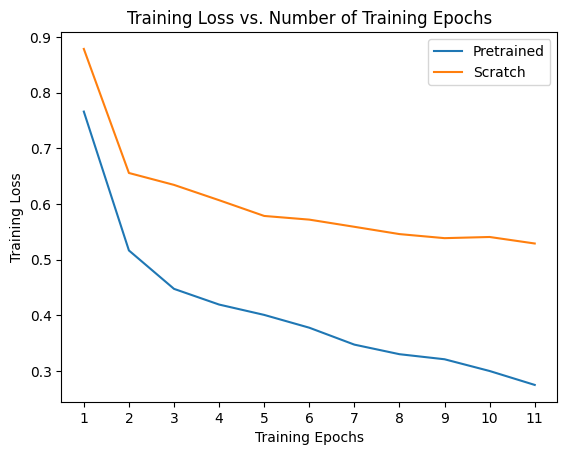

In [24]:
plt.title("Training Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Training Loss")
plt.plot(range(1,num_epochs+1),ohist_train_loss,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist_train_loss,label="Scratch")
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

## 10000

In [ ]:
dataset_10000 = torch.utils.data.Subset(dataset, range(10000)) # Para un primer intento, dataset de 100 imagenes 

# Definir tamaño de los conjuntos de entrenamiento y validación
train_size = int(0.8 * len(dataset_10000))
val_size = len(dataset_10000) - train_size

# Dividir el dataset en conjuntos de entrenamiento y validación de manera aleatoria
train_data, val_data = random_split(dataset_10000, [train_size, val_size])

In [ ]:
# Creamos un diccionario con los datasets de entrenamiento y validación
image_datasets = {'train': train_data, 'val': val_data}

# Creamos un diccionario con los dataloaders del diccionario image_datasets
batch_size = 8
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'val']}

In [ ]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist_val_acc, hist_val_loss, hist_train_acc, hist_train_loss = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/10
----------
train Loss: 0.6474 Acc: 0.7609
val Loss: 0.5202 Acc: 0.8195

Epoch 1/10
----------
train Loss: 0.4765 Acc: 0.8216
val Loss: 0.4564 Acc: 0.8345

Epoch 2/10
----------
train Loss: 0.4342 Acc: 0.8306
val Loss: 0.4441 Acc: 0.8215

Epoch 3/10
----------
train Loss: 0.4153 Acc: 0.8400
val Loss: 0.4218 Acc: 0.8275

Epoch 4/10
----------
train Loss: 0.4003 Acc: 0.8430
val Loss: 0.4727 Acc: 0.8425

Epoch 5/10
----------
train Loss: 0.3795 Acc: 0.8479
val Loss: 0.5534 Acc: 0.8105

Epoch 6/10
----------
train Loss: 0.3684 Acc: 0.8559
val Loss: 0.4040 Acc: 0.8450

Epoch 7/10
----------
train Loss: 0.3615 Acc: 0.8566
val Loss: 0.4360 Acc: 0.8390

Epoch 8/10
----------
train Loss: 0.3424 Acc: 0.8655
val Loss: 0.4409 Acc: 0.8440

Epoch 9/10
----------
train Loss: 0.3267 Acc: 0.8718
val Loss: 0.4284 Acc: 0.8435

Epoch 10/10
----------
train Loss: 0.3144 Acc: 0.8738
val Loss: 0.4511 Acc: 0.8395

Training complete in 67m 44s
Best val Acc: 0.845000


In [ ]:
# Initialize the non-pretrained version of the model used for this run
scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_, scratch_hist_val_acc, scratch_hist_val_loss, scratch_hist_train_acc, scratch_hist_train_loss = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/10
----------


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


train Loss: 0.8587 Acc: 0.6352
val Loss: 0.7575 Acc: 0.6895

Epoch 1/10
----------
train Loss: 0.6568 Acc: 0.7286
val Loss: 0.5666 Acc: 0.7610

Epoch 2/10
----------
train Loss: 0.6054 Acc: 0.7411
val Loss: 0.5292 Acc: 0.7680

Epoch 3/10
----------
train Loss: 0.5800 Acc: 0.7479
val Loss: 0.5364 Acc: 0.7665

Epoch 4/10
----------
train Loss: 0.5640 Acc: 0.7486
val Loss: 0.5315 Acc: 0.7620

Epoch 5/10
----------
train Loss: 0.5607 Acc: 0.7504
val Loss: 0.5032 Acc: 0.7665

Epoch 6/10
----------
train Loss: 0.5508 Acc: 0.7539
val Loss: 0.5461 Acc: 0.7560

Epoch 7/10
----------
train Loss: 0.5390 Acc: 0.7578
val Loss: 0.5630 Acc: 0.7530

Epoch 8/10
----------
train Loss: 0.5275 Acc: 0.7616
val Loss: 0.5077 Acc: 0.7725

Epoch 9/10
----------
train Loss: 0.5315 Acc: 0.7618
val Loss: 0.5355 Acc: 0.7620

Epoch 10/10
----------
train Loss: 0.5247 Acc: 0.7634
val Loss: 0.4906 Acc: 0.7720

Training complete in 68m 17s
Best val Acc: 0.772500


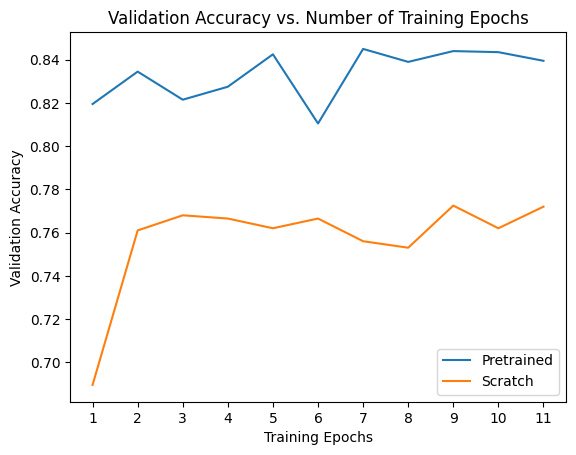

In [25]:
ohist_val_acc = [0.8195, 0.8345, 0.8215, 0.8275, 0.8425, 0.8105, 0.8450, 0.8390, 0.8440, 0.8435, 0.8395]
shist_val_acc = [0.6895, 0.7610, 0.7680, 0.7665, 0.7620, 0.7665, 0.7560, 0.7530, 0.7725, 0.7620, 0.7720]
ohist_train_acc = [0.7609, 0.8216, 0.8306, 0.8400, 0.8430, 0.8479, 0.8559, 0.8566, 0.8655, 0.8718, 0.8738]
shist_train_acc = [0.6352, 0.7286, 0.7411, 0.7479, 0.7486, 0.7504, 0.7539, 0.7578, 0.7616, 0.7618, 0.7634]
ohist_val_loss = [0.5202, 0.4564, 0.4441, 0.4218, 0.4727, 0.5534, 0.4040, 0.4360, 0.4409, 0.4284, 0.4511]
shist_val_loss = [0.7575, 0.5666, 0.5292, 0.5364, 0.5315, 0.5032, 0.5461, 0.5630, 0.5077, 0.5355, 0.4906]
ohist_train_loss = [0.6474, 0.4765, 0.4342, 0.4153, 0.4003, 0.3795, 0.3684, 0.3615, 0.3424, 0.3267, 0.3144]
shist_train_loss = [0.8587, 0.6568, 0.6054, 0.5800, 0.5640, 0.5607, 0.5508, 0.5390, 0.5275, 0.5315, 0.5247]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist_val_acc,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist_val_acc,label="Scratch")
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

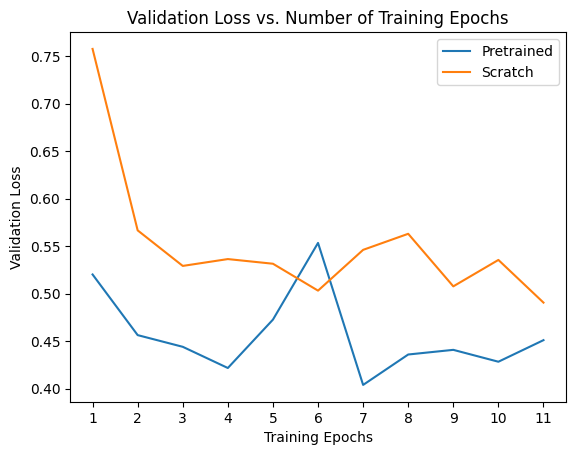

In [26]:
plt.title("Validation Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Loss")
plt.plot(range(1,num_epochs+1),ohist_val_loss,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist_val_loss,label="Scratch")
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

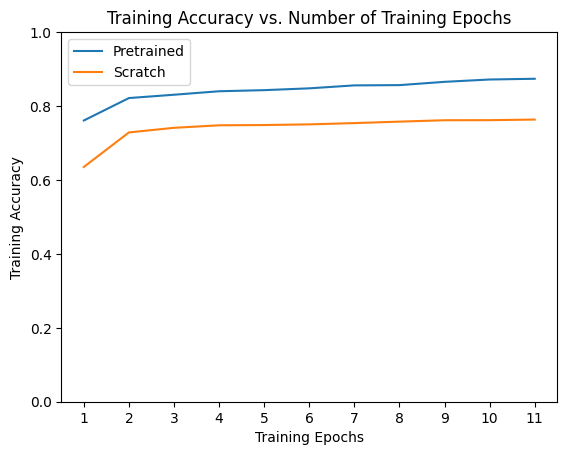

In [27]:
plt.title("Training Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Training Accuracy")
plt.plot(range(1,num_epochs+1),ohist_train_acc,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist_train_acc,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

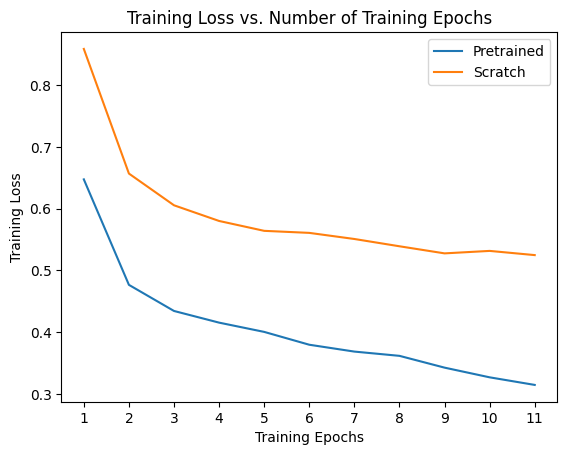

In [28]:
plt.title("Training Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Training Loss")
plt.plot(range(1,num_epochs+1),ohist_train_loss,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist_train_loss,label="Scratch")
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

## 15000 COMPROBAR

In [11]:
dataset_15000 = torch.utils.data.Subset(dataset, range(15000)) # Para un primer intento, dataset de 100 imagenes 

# Definir tamaño de los conjuntos de entrenamiento y validación
train_size = int(0.8 * len(dataset_15000))
val_size = len(dataset_15000) - train_size

# Dividir el dataset en conjuntos de entrenamiento y validación de manera aleatoria
train_data, val_data = random_split(dataset_15000, [train_size, val_size])

In [12]:
# Creamos un diccionario con los datasets de entrenamiento y validación
image_datasets = {'train': train_data, 'val': val_data}

# Creamos un diccionario con los dataloaders del diccionario image_datasets
batch_size = 8
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'val']}

In [ ]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist_val_acc, hist_val_loss, hist_train_acc, hist_train_loss = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/10
----------
train Loss: 0.6144 Acc: 0.7681
val Loss: 0.4593 Acc: 0.8190

Epoch 1/10
----------
train Loss: 0.4611 Acc: 0.8265
val Loss: 0.4419 Acc: 0.8427

Epoch 2/10
----------
train Loss: 0.4285 Acc: 0.8370
val Loss: 0.4005 Acc: 0.8383

Epoch 3/10
----------
train Loss: 0.4050 Acc: 0.8415
val Loss: 0.4038 Acc: 0.8480

Epoch 4/10
----------
train Loss: 0.3886 Acc: 0.8500
val Loss: 0.4021 Acc: 0.8493

Epoch 5/10
----------
train Loss: 0.3735 Acc: 0.8510
val Loss: 0.3910 Acc: 0.8463

Epoch 6/10
----------
train Loss: 0.3577 Acc: 0.8608
val Loss: 0.4014 Acc: 0.8380

Epoch 7/10
----------
train Loss: 0.3449 Acc: 0.8643
val Loss: 0.3943 Acc: 0.8467

Epoch 8/10
----------
train Loss: 0.3356 Acc: 0.8678
val Loss: 0.3765 Acc: 0.8503

Epoch 9/10
----------
train Loss: 0.3254 Acc: 0.8707
val Loss: 0.4484 Acc: 0.8240

Epoch 10/10
----------
train Loss: 0.3149 Acc: 0.8766
val Loss: 0.4318 Acc: 0.8380

Training complete in 44m 26s
Best val Acc: 0.850333


In [ ]:
# Initialize the non-pretrained version of the model used for this run
scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_, scratch_hist_val_acc, scratch_hist_val_loss, scratch_hist_train_acc, scratch_hist_train_loss = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/10
----------


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
ohist_val_acc = []
shist_val_acc = []

ohist_val_acc = [h.cpu().numpy() for h in hist_val_acc]
shist_val_acc = [h.cpu().numpy() for h in scratch_hist_val_acc]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist_val_acc,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist_val_acc,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

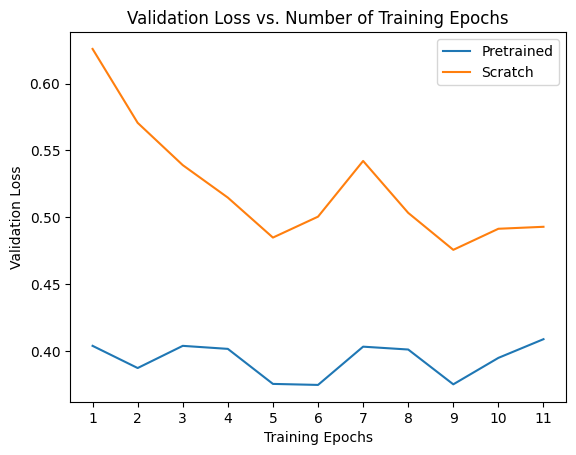

In [ ]:
ohist_val_loss = []
shist_val_loss = []

ohist_val_loss = [h for h in hist_val_loss]
shist_val_loss = [h for h in scratch_hist_val_loss]

plt.title("Validation Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Loss")
plt.plot(range(1,num_epochs+1),ohist_val_loss,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist_val_loss,label="Scratch")
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

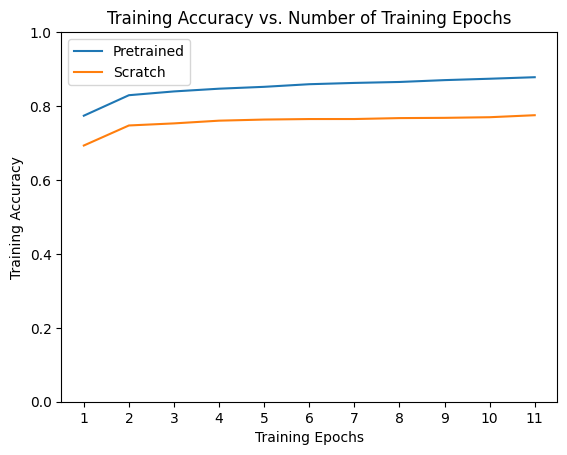

In [ ]:
ohist_train_acc = []
shist_train_acc = []

ohist_train_acc = [h.cpu().numpy() for h in hist_train_acc]
shist_train_acc = [h.cpu().numpy() for h in scratch_hist_train_acc]

plt.title("Training Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Training Accuracy")
plt.plot(range(1,num_epochs+1),ohist_train_acc,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist_train_acc,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

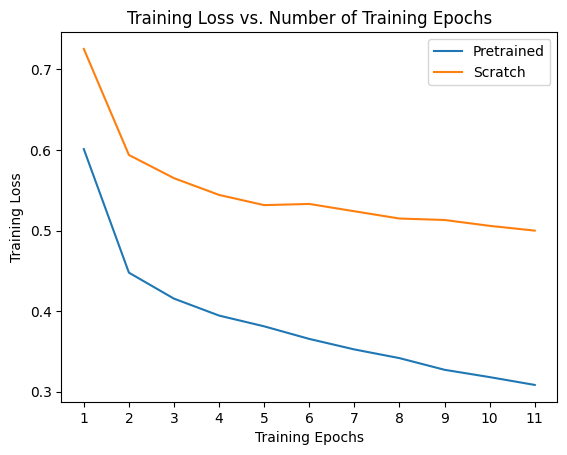

In [ ]:
ohist_train_loss = []
shist_train_loss = []

ohist_train_loss = [h for h in hist_train_loss]
shist_train_loss = [h for h in scratch_hist_train_loss]

plt.title("Training Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Training Loss")
plt.plot(range(1,num_epochs+1),ohist_train_loss,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist_train_loss,label="Scratch")
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

# Probamos con 50 Epochs de training

In [11]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
#data_dir = "./content/drive/MyDrive/Dataset_hymenoptera/hymenoptera_data"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "squeezenet"

# Number of classes in the dataset
num_classes = 4

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for
num_epochs = 50

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False

## 100

In [ ]:
dataset_100 = torch.utils.data.Subset(dataset, range(100)) # Para un primer intento, dataset de 100 imagenes 

# Definir tamaño de los conjuntos de entrenamiento y validación
train_size = int(0.8 * len(dataset_100))
val_size = len(dataset_100) - train_size

# Dividir el dataset en conjuntos de entrenamiento y validación de manera aleatoria
train_data, val_data = random_split(dataset_100, [train_size, val_size])

In [ ]:
# Creamos un diccionario con los datasets de entrenamiento y validación
image_datasets = {'train': train_data, 'val': val_data}

# Creamos un diccionario con los dataloaders del diccionario image_datasets
batch_size = 8
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'val']}

In [ ]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist_val_acc, hist_val_loss, hist_train_acc, hist_train_loss = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/49
----------
train Loss: 1.4766 Acc: 0.3625
val Loss: 1.1770 Acc: 0.5500

Epoch 1/49
----------
train Loss: 1.1680 Acc: 0.6250
val Loss: 0.9075 Acc: 0.6500

Epoch 2/49
----------
train Loss: 0.8524 Acc: 0.6625
val Loss: 0.6912 Acc: 0.7000

Epoch 3/49
----------
train Loss: 1.0037 Acc: 0.6375
val Loss: 0.8413 Acc: 0.6500

Epoch 4/49
----------
train Loss: 1.0352 Acc: 0.5125
val Loss: 0.8089 Acc: 0.5500

Epoch 5/49
----------
train Loss: 0.7998 Acc: 0.7375
val Loss: 0.9541 Acc: 0.6500

Epoch 6/49
----------
train Loss: 0.6318 Acc: 0.7750
val Loss: 0.7625 Acc: 0.7000

Epoch 7/49
----------
train Loss: 0.4870 Acc: 0.8375
val Loss: 0.5682 Acc: 0.8000

Epoch 8/49
----------
train Loss: 0.3282 Acc: 0.8375
val Loss: 0.5559 Acc: 0.8000

Epoch 9/49
----------
train Loss: 0.2098 Acc: 0.9000
val Loss: 0.8965 Acc: 0.7500

Epoch 10/49
----------
train Loss: 0.1640 Acc: 0.9375
val Loss: 1.9301 Acc: 0.7000

Epoch 11/49
----------
train Loss: 0.4290 Acc: 0.8750
val Loss: 1.8236 Acc: 0.7500

Ep

In [ ]:
# Initialize the non-pretrained version of the model used for this run
scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_, scratch_hist_val_acc, scratch_hist_val_loss, scratch_hist_train_acc, scratch_hist_train_loss = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/49
----------


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


train Loss: 1.3749 Acc: 0.2500
val Loss: 1.3708 Acc: 0.2500

Epoch 1/49
----------
train Loss: 1.2712 Acc: 0.3500
val Loss: 1.2521 Acc: 0.5000

Epoch 2/49
----------
train Loss: 1.2553 Acc: 0.3875
val Loss: 1.2876 Acc: 0.2500

Epoch 3/49
----------
train Loss: 1.2079 Acc: 0.3625
val Loss: 1.2116 Acc: 0.6000

Epoch 4/49
----------
train Loss: 1.1460 Acc: 0.5625
val Loss: 1.1334 Acc: 0.5500

Epoch 5/49
----------
train Loss: 1.0718 Acc: 0.6375
val Loss: 1.1640 Acc: 0.6000

Epoch 6/49
----------
train Loss: 1.0944 Acc: 0.5625
val Loss: 1.0374 Acc: 0.6000

Epoch 7/49
----------
train Loss: 1.0027 Acc: 0.5875
val Loss: 1.0341 Acc: 0.6000

Epoch 8/49
----------
train Loss: 0.9956 Acc: 0.6125
val Loss: 0.9169 Acc: 0.6000

Epoch 9/49
----------
train Loss: 0.8650 Acc: 0.6375
val Loss: 0.9028 Acc: 0.6000

Epoch 10/49
----------
train Loss: 0.8465 Acc: 0.6625
val Loss: 0.8214 Acc: 0.6500

Epoch 11/49
----------
train Loss: 0.8391 Acc: 0.6250
val Loss: 0.9960 Acc: 0.5500

Epoch 12/49
----------
t

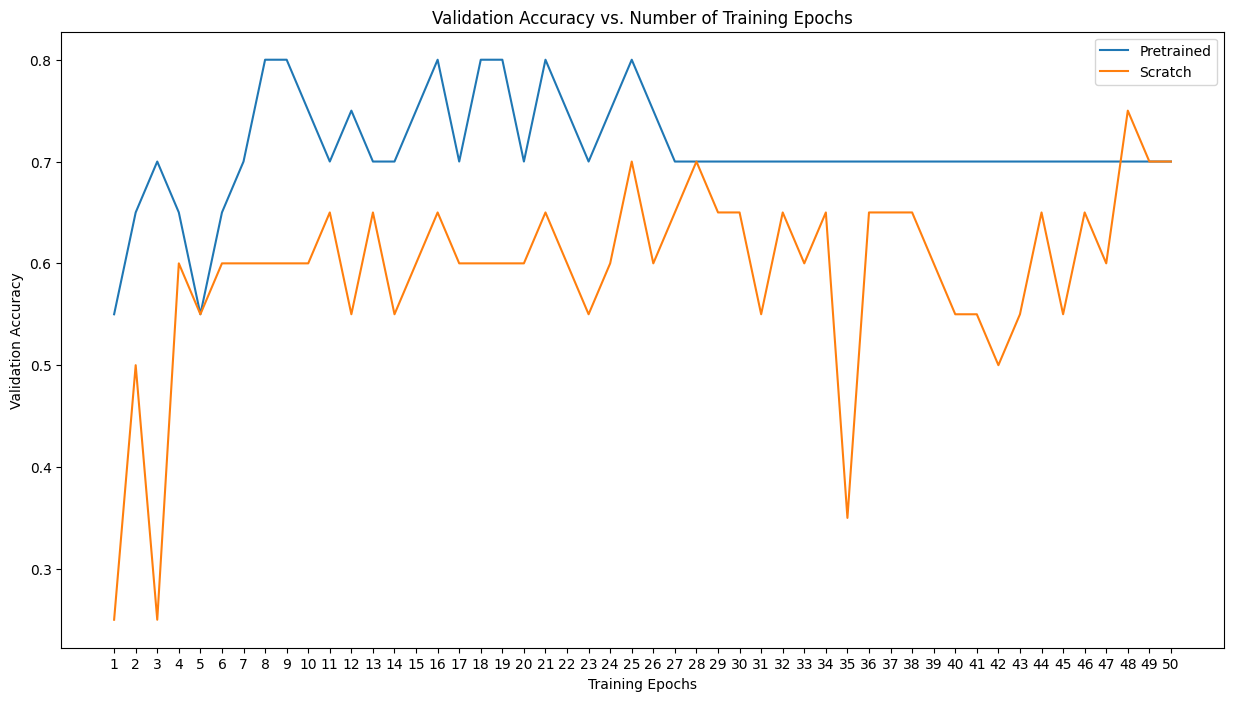

In [12]:
ohist_val_acc = [0.5500, 0.6500, 0.7000, 0.6500, 0.5500, 0.6500, 0.7000, 0.8000, 0.8000, 0.7500, 0.7000, 0.7500, 0.7000, 0.7000, 0.7500, 0.8000, 0.7000, 0.8000, 0.8000, 0.7000, 0.8000, 0.7500, 0.7000, 0.7500, 0.8000, 0.7500, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000]
shist_val_acc = [0.2500, 0.5000, 0.2500, 0.6000, 0.5500, 0.6000, 0.6000, 0.6000, 0.6000, 0.6000, 0.6500, 0.5500, 0.6500, 0.5500, 0.6000, 0.6500, 0.6000, 0.6000, 0.6000, 0.6000, 0.6500, 0.6000, 0.5500, 0.6000, 0.7000, 0.6000, 0.6500, 0.7000, 0.6500, 0.6500, 0.5500, 0.6500, 0.6000, 0.6500, 0.3500, 0.6500, 0.6500, 0.6500, 0.6000, 0.5500, 0.5500, 0.5000, 0.5500, 0.6500, 0.5500, 0.6500, 0.6000, 0.7500, 0.7000, 0.7000]
ohist_train_acc = [0.3625, 0.6250, 0.6625, 0.6375, 0.5125, 0.7375, 0.7750, 0.8375, 0.8375, 0.9000, 0.9375, 0.8750, 0.7375, 0.7750, 0.8250, 0.9125, 0.9625, 0.9625, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000]
shist_train_acc = [0.2500, 0.3500, 0.3875, 0.3625, 0.5625, 0.6375, 0.5625, 0.5875, 0.6125, 0.6375, 0.6625, 0.6250, 0.6375, 0.6625, 0.6375, 0.6125, 0.6250, 0.6500, 0.6125, 0.6500, 0.6125, 0.7000, 0.6875, 0.6375, 0.6375, 0.7000, 0.7250, 0.6375, 0.6375, 0.7125, 0.7125, 0.7250, 0.7750, 0.7625, 0.5500, 0.6750, 0.6375, 0.6875, 0.6750, 0.6875, 0.7000, 0.7000, 0.6625, 0.6500, 0.7000, 0.7250, 0.7500, 0.7875, 0.7875, 0.8000]
ohist_val_loss = [1.1770, 0.9075, 0.6912, 0.8413, 0.8089, 0.9541, 0.7625, 0.5682, 0.5559, 0.8965, 1.9301, 1.8236, 0.8787, 0.8073, 0.7540, 1.2452, 1.1773, 0.9417, 1.7841, 1.4183, 2.3130, 2.2285, 1.8981, 2.1809, 2.6168, 2.5225, 2.3063, 2.2140, 2.2504, 2.3352, 2.3822, 2.4156, 2.4768, 2.5019, 2.5253, 2.5540, 2.5373, 2.5248, 2.5222, 2.3680, 2.3663, 2.3859, 2.4200, 2.4514, 2.4596, 2.4610, 2.4618, 2.4680, 2.4685, 2.4871]
shist_val_loss = [1.3708, 1.2521, 1.2876, 1.2116, 1.1334, 1.1640, 1.0374, 1.0341, 0.9169, 0.9028, 0.8214, 0.9960, 1.0415, 0.9734, 0.8763, 0.8458, 0.8040, 0.8194, 0.8398, 1.0593, 0.9227, 0.7678, 0.8452, 0.8007, 0.8922, 0.9258, 0.8846, 0.8288, 0.8091, 0.8181, 0.8086, 0.8334, 1.1499, 0.8492, 1.1474, 0.8795, 0.8705, 0.8526, 0.8816, 0.9410, 0.8791, 0.9803, 0.9564, 1.2688, 0.9754, 0.8282, 0.9360, 1.1672, 1.4212, 1.9345]
ohist_train_loss = [1.4766, 1.1680, 0.8524, 1.0037, 1.0352, 0.7998, 0.6318, 0.4870, 0.3282, 0.2098, 0.1640, 0.4290, 0.7466, 0.6643, 0.4236, 0.2719, 0.1182, 0.1057, 0.0250, 0.0272, 0.0196, 0.0160, 0.0032, 0.0080, 0.0051, 0.0036, 0.0016, 0.0004, 0.0031, 0.0010, 0.0012, 0.0013, 0.0004, 0.0004, 0.0006, 0.0003, 0.0003, 0.0002, 0.0004, 0.0023, 0.0004, 0.0002, 0.0006, 0.0002, 0.0006, 0.0002, 0.0001, 0.0001, 0.0006, 0.0002]
shist_train_loss = [1.3749, 1.2712, 1.2553, 1.2079, 1.1460, 1.0718, 1.0944, 1.0027, 0.9956, 0.8650, 0.8465, 0.8391, 0.7899, 0.8302, 0.7750, 0.8580, 0.8208, 0.7616, 0.8094, 0.7142, 0.7729, 0.6960, 0.6469, 0.6922, 0.6876, 0.7381, 0.6861, 0.8105, 0.7286, 0.6250, 0.6339, 0.5735, 0.4882, 0.5155, 0.9817, 0.8895, 0.8878, 0.7621, 0.6634, 0.6558, 0.6628, 0.6169, 0.6154, 0.5555, 0.6526, 0.5677, 0.5125, 0.4599, 0.4402, 0.4740]

plt.figure(figsize=(15, 8)) # Ajustar el tamaño de la figura
plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist_val_acc,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist_val_acc,label="Scratch")
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

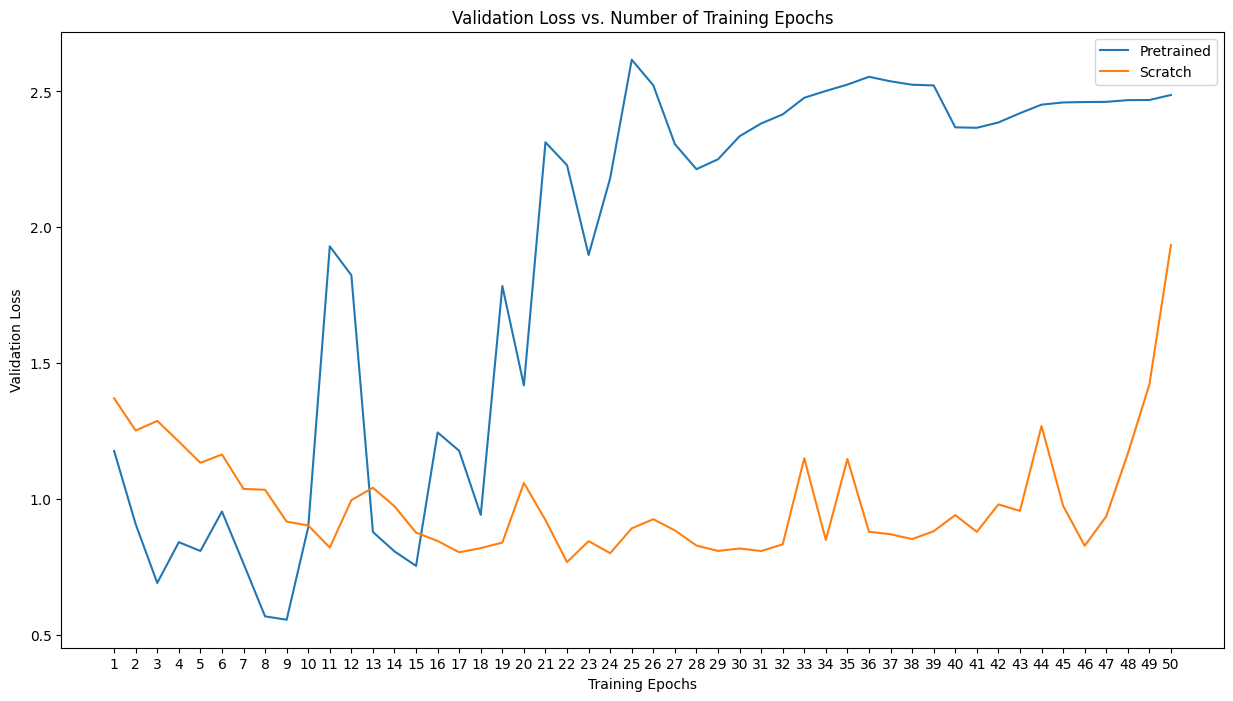

In [13]:
plt.figure(figsize=(15, 8)) # Ajustar el tamaño de la figura
plt.title("Validation Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Loss")
plt.plot(range(1,num_epochs+1),ohist_val_loss,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist_val_loss,label="Scratch")
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

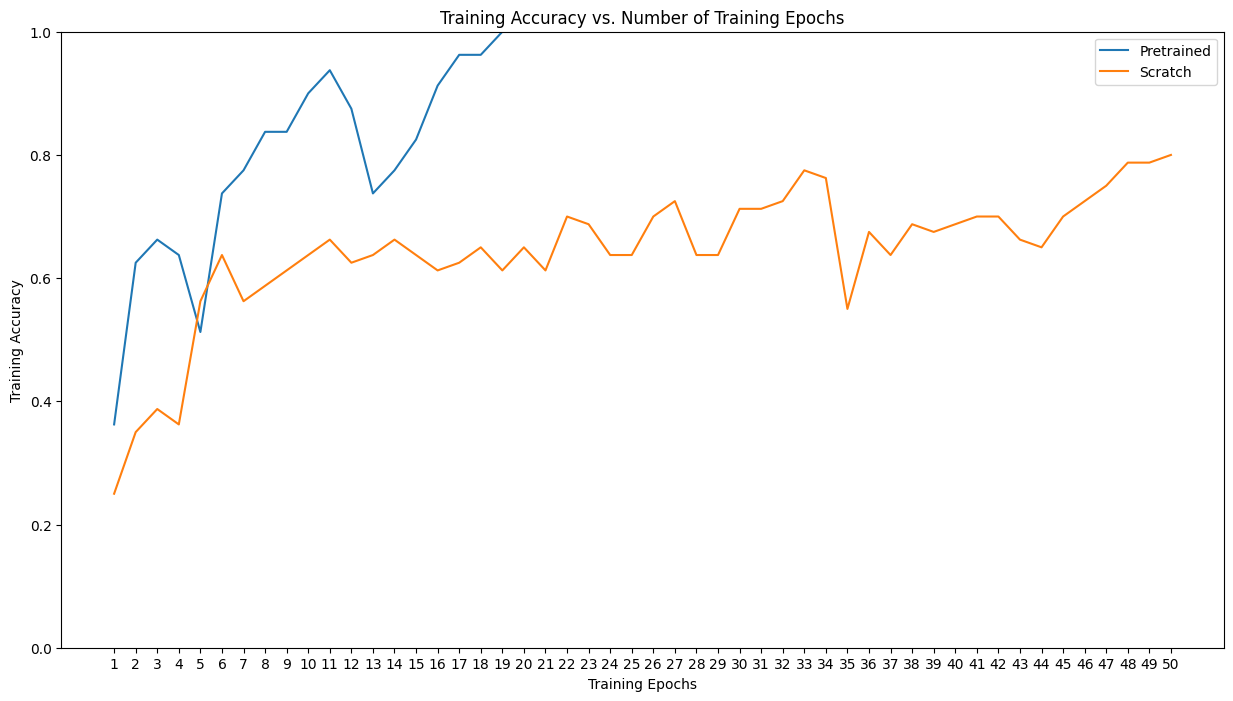

In [14]:
plt.figure(figsize=(15, 8)) # Ajustar el tamaño de la figura
plt.title("Training Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Training Accuracy")
plt.plot(range(1,num_epochs+1),ohist_train_acc,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist_train_acc,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

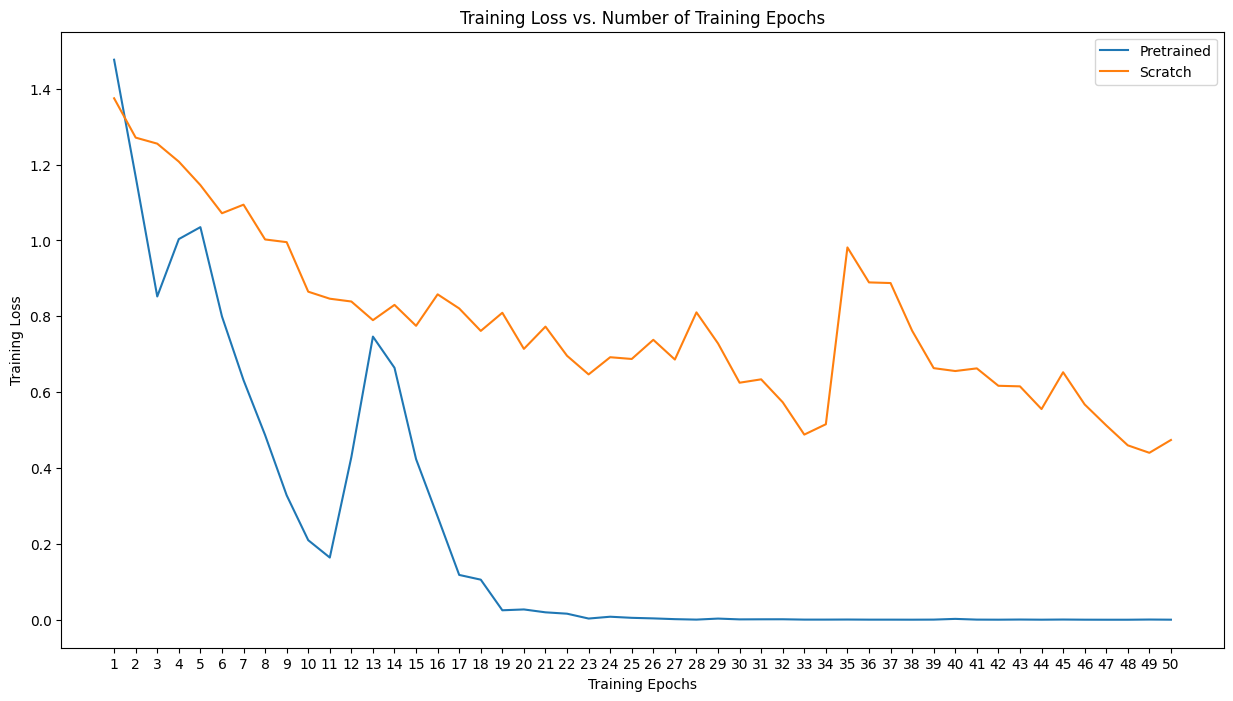

In [15]:
plt.figure(figsize=(15, 8)) # Ajustar el tamaño de la figura
plt.title("Training Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Training Loss")
plt.plot(range(1,num_epochs+1),ohist_train_loss,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist_train_loss,label="Scratch")
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

## 1000

In [ ]:
dataset_100 = torch.utils.data.Subset(dataset, range(1000)) # Para un primer intento, dataset de 100 imagenes 

# Definir tamaño de los conjuntos de entrenamiento y validación
train_size = int(0.8 * len(dataset_100))
val_size = len(dataset_100) - train_size

# Dividir el dataset en conjuntos de entrenamiento y validación de manera aleatoria
train_data, val_data = random_split(dataset_100, [train_size, val_size])

In [ ]:
# Creamos un diccionario con los datasets de entrenamiento y validación
image_datasets = {'train': train_data, 'val': val_data}

# Creamos un diccionario con los dataloaders del diccionario image_datasets
batch_size = 8
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'val']}

In [ ]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist_val_acc, hist_val_loss, hist_train_acc, hist_train_loss = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/49
----------
train Loss: 1.1435 Acc: 0.5325
val Loss: 0.8099 Acc: 0.6850

Epoch 1/49
----------
train Loss: 0.7521 Acc: 0.7362
val Loss: 0.5656 Acc: 0.7750

Epoch 2/49
----------
train Loss: 0.6135 Acc: 0.7812
val Loss: 0.5218 Acc: 0.8400

Epoch 3/49
----------
train Loss: 0.5978 Acc: 0.7712
val Loss: 0.6996 Acc: 0.7300

Epoch 4/49
----------
train Loss: 0.5189 Acc: 0.8063
val Loss: 0.4667 Acc: 0.8250

Epoch 5/49
----------
train Loss: 0.4728 Acc: 0.8113
val Loss: 0.4792 Acc: 0.8550

Epoch 6/49
----------
train Loss: 0.4168 Acc: 0.8375
val Loss: 0.4816 Acc: 0.8650

Epoch 7/49
----------
train Loss: 0.3745 Acc: 0.8638
val Loss: 0.5081 Acc: 0.8700

Epoch 8/49
----------
train Loss: 0.4161 Acc: 0.8387
val Loss: 0.4463 Acc: 0.8300

Epoch 9/49
----------
train Loss: 0.3172 Acc: 0.8700
val Loss: 0.4874 Acc: 0.8100

Epoch 10/49
----------
train Loss: 0.2872 Acc: 0.8912
val Loss: 0.4700 Acc: 0.8400

Epoch 11/49
----------
train Loss: 0.2684 Acc: 0.8975
val Loss: 0.5006 Acc: 0.8350

Ep

In [ ]:
# Initialize the non-pretrained version of the model used for this run
scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_, scratch_hist_val_acc, scratch_hist_val_loss, scratch_hist_train_acc, scratch_hist_train_loss = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/49
----------


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


train Loss: 1.2669 Acc: 0.3488
val Loss: 1.1849 Acc: 0.3750

Epoch 1/49
----------
train Loss: 0.9580 Acc: 0.5763
val Loss: 0.6231 Acc: 0.7300

Epoch 2/49
----------
train Loss: 0.7838 Acc: 0.6837
val Loss: 0.9142 Acc: 0.5900

Epoch 3/49
----------
train Loss: 0.7416 Acc: 0.7512
val Loss: 0.7471 Acc: 0.8050

Epoch 4/49
----------
train Loss: 0.6499 Acc: 0.7963
val Loss: 0.6753 Acc: 0.7300

Epoch 5/49
----------
train Loss: 0.5924 Acc: 0.7950
val Loss: 0.4686 Acc: 0.8550

Epoch 6/49
----------
train Loss: 0.5728 Acc: 0.7975
val Loss: 0.4879 Acc: 0.7950

Epoch 7/49
----------
train Loss: 0.5780 Acc: 0.8113
val Loss: 0.4484 Acc: 0.8350

Epoch 8/49
----------
train Loss: 0.5328 Acc: 0.8025
val Loss: 0.4307 Acc: 0.8200

Epoch 9/49
----------
train Loss: 0.5940 Acc: 0.7825
val Loss: 0.4216 Acc: 0.8450

Epoch 10/49
----------
train Loss: 0.5334 Acc: 0.7988
val Loss: 0.6011 Acc: 0.7950

Epoch 11/49
----------
train Loss: 0.5075 Acc: 0.8063
val Loss: 0.4768 Acc: 0.8300

Epoch 12/49
----------
t

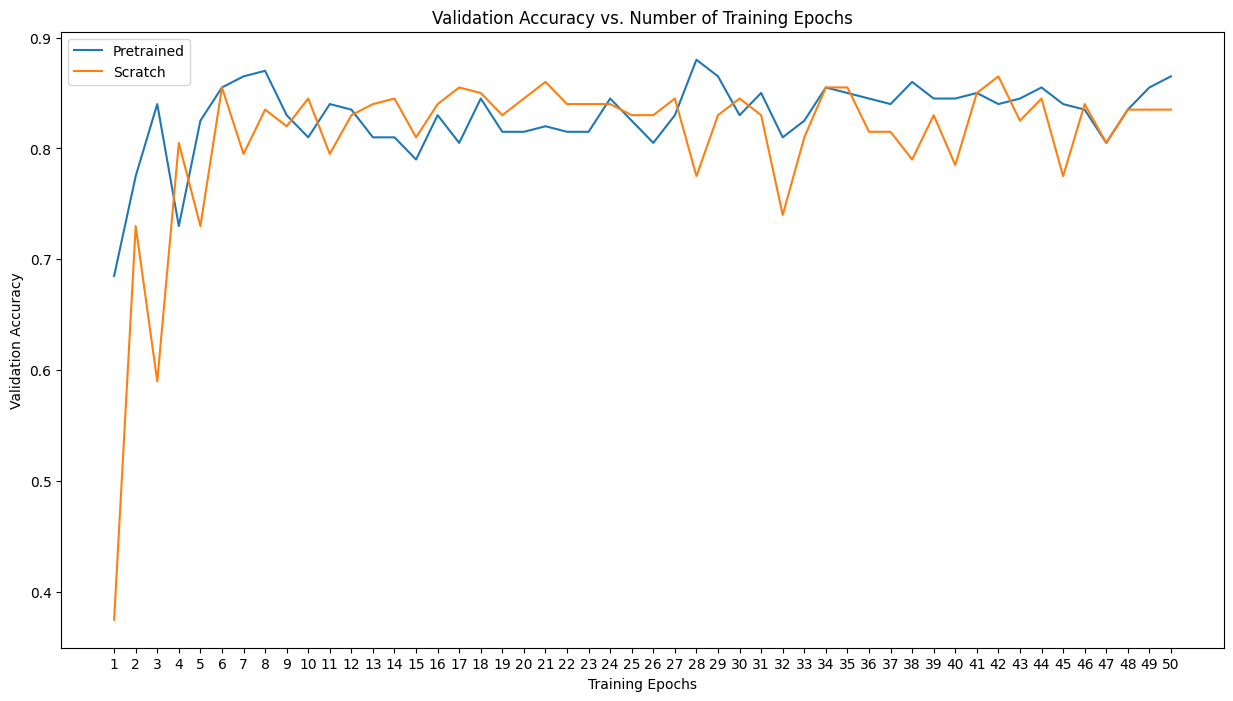

In [16]:
ohist_val_acc = [0.6850, 0.7750, 0.8400, 0.7300, 0.8250, 0.8550, 0.8650, 0.8700, 0.8300, 0.8100, 0.8400, 0.8350, 0.8100, 0.8100, 0.7900, 0.8300, 0.8050, 0.8450, 0.8150, 0.8150, 0.8200, 0.8150, 0.8150, 0.8450, 0.8250, 0.8050, 0.8300, 0.8800, 0.8650, 0.8300, 0.8500, 0.8100, 0.8250, 0.8550, 0.8500, 0.8450, 0.8400, 0.8600, 0.8450, 0.8450, 0.8500, 0.8400, 0.8450, 0.8550, 0.8400, 0.8350, 0.8050, 0.8350, 0.8550, 0.8650]

shist_val_acc = [0.3750, 0.7300, 0.5900, 0.8050, 0.7300, 0.8550, 0.7950, 0.8350, 0.8200, 0.8450, 0.7950, 0.8300, 0.8400, 0.8450, 0.8100, 0.8400, 0.8550, 0.8500, 0.8300, 0.8450, 0.8600, 0.8400, 0.8400, 0.8400, 0.8300, 0.8300, 0.8450, 0.7750, 0.8300, 0.8450, 0.8300, 0.7400, 0.8100, 0.8550, 0.8550, 0.8150, 0.8150, 0.7900, 0.8300, 0.7850, 0.8500, 0.8650, 0.8250, 0.8450, 0.7750, 0.8400, 0.8050, 0.8350, 0.8350, 0.8350]

ohist_train_acc = [0.5325, 0.7362, 0.7812, 0.7712, 0.8063, 0.8113, 0.8375, 0.8638, 0.8387, 0.8700, 0.8912, 0.8975, 0.9038, 0.9113, 0.9188, 0.9000, 0.9287, 0.9375, 0.9513, 0.9563, 0.9450, 0.9750, 0.9525, 0.9513, 0.9525, 0.9675, 0.9337, 0.9450, 0.9300, 0.9838, 0.9950, 0.9900, 0.9875, 0.9075, 0.9563, 0.9775, 0.9813, 0.9813, 0.9788, 0.9875, 0.9988, 0.9988, 0.9988, 0.9988, 0.9988, 0.9913, 0.9575, 0.9863, 0.9875, 0.9925]

shist_train_acc = [0.3488, 0.5763, 0.6837, 0.7512, 0.7963, 0.7950, 0.7975, 0.8113, 0.8025, 0.7825, 0.7988, 0.8063, 0.7838, 0.8087, 0.8163, 0.8313, 0.8000, 0.8325, 0.8400, 0.8375, 0.8213, 0.8250, 0.8300, 0.8337, 0.8363, 0.8413, 0.8350, 0.8325, 0.8400, 0.8250, 0.8413, 0.8513, 0.8413, 0.8575, 0.8575, 0.8463, 0.8413, 0.8575, 0.8575, 0.8700, 0.8588, 0.8838, 0.8688, 0.8838, 0.8750, 0.8712, 0.8550, 0.8788, 0.8788, 0.8938]

ohist_val_loss = [0.8099, 0.5656, 0.5218, 0.6996, 0.4667, 0.4792, 0.4816, 0.5081, 0.4463, 0.4874, 0.4700, 0.5006, 0.5260, 0.4994, 0.6890, 0.6826, 0.6357, 0.6727, 0.6300, 0.8527, 0.6261, 0.7742, 0.5658, 0.8748, 0.9122, 1.1597, 0.8136, 0.7212, 0.4515, 0.6953, 0.8408, 0.9479, 1.3200, 0.7199, 0.8084, 0.8376, 0.8411, 0.7623, 0.8340, 0.9869, 1.0155, 1.0518, 1.0660, 1.1133, 1.0410, 0.6251, 1.0640, 0.8973, 0.8016, 1.1772]

shist_val_loss = [1.1849, 0.6231, 0.9142, 0.7471, 0.6753, 0.4686, 0.4879, 0.4484, 0.4307, 0.4216, 0.6011, 0.4768, 0.4045, 0.4394, 0.4824, 0.4278, 0.4213, 0.4247, 0.4187, 0.4079, 0.4171, 0.4077, 0.4506, 0.4137, 0.4606, 0.4119, 0.4186, 0.6456, 0.4717, 0.4070, 0.4663, 0.6635, 0.4933, 0.4346, 0.4306, 0.5063, 0.5228, 0.5836, 0.4603, 0.5225, 0.4354, 0.4439, 0.4905, 0.4584, 0.5650, 0.4706, 0.5115, 0.5067, 0.5163, 0.5000]

ohist_train_loss = [1.1435, 0.7521, 0.6135, 0.5978, 0.5189, 0.4728, 0.4168, 0.3745, 0.4161, 0.3172, 0.2872, 0.2684, 0.2646, 0.2085, 0.2242, 0.2630, 0.1858, 0.1669, 0.1545, 0.1322, 0.1524, 0.0918, 0.1586, 0.1464, 0.1229, 0.0863, 0.1723, 0.1778, 0.2312, 0.0598, 0.0282, 0.0332, 0.0502, 0.2760, 0.1446, 0.0608, 0.0590, 0.0654, 0.0463, 0.0119, 0.0128, 0.0100, 0.0092, 0.0099, 0.0248, 0.1165, 0.0447, 0.0646, 0.0259, 0.0159]

shist_train_loss = [1.2669, 0.9580, 0.7838, 0.7416, 0.6499, 0.5924, 0.5728, 0.5780, 0.5328, 0.5940, 0.5334, 0.5075, 0.5075, 0.5260, 0.4968, 0.4968, 0.4968, 0.4756, 0.4503, 0.4518, 0.4530, 0.4602, 0.4736, 0.4377, 0.4183, 0.4255, 0.4339, 0.4208, 0.4389, 0.4196, 0.4220, 0.3762, 0.4179, 0.3805, 0.3805, 0.3892, 0.4059, 0.3736, 0.3716, 0.3450, 0.3608, 0.3145, 0.3335, 0.3130, 0.3409, 0.3326, 0.3674, 0.3187, 0.2912, 0.2854]

plt.figure(figsize=(15, 8)) # Ajustar el tamaño de la figura
plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist_val_acc,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist_val_acc,label="Scratch")
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

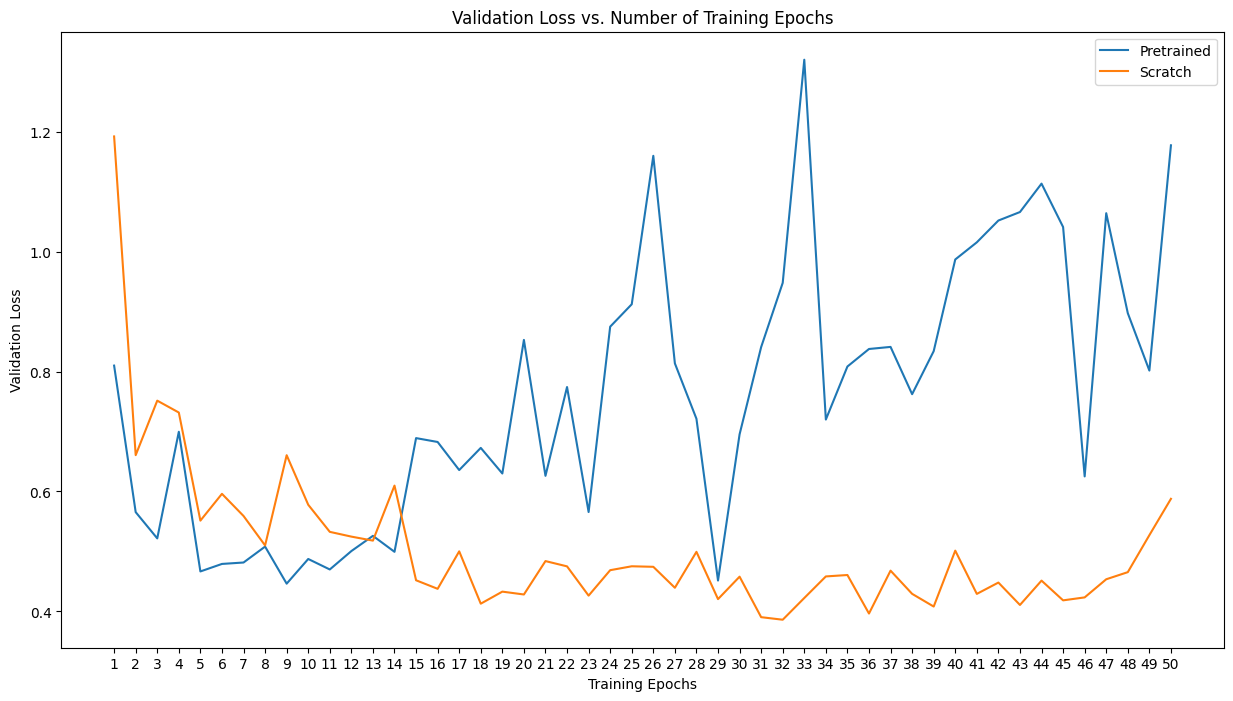

In [ ]:
plt.figure(figsize=(15, 8)) # Ajustar el tamaño de la figura
plt.title("Validation Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Loss")
plt.plot(range(1,num_epochs+1),ohist_val_loss,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist_val_loss,label="Scratch")
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

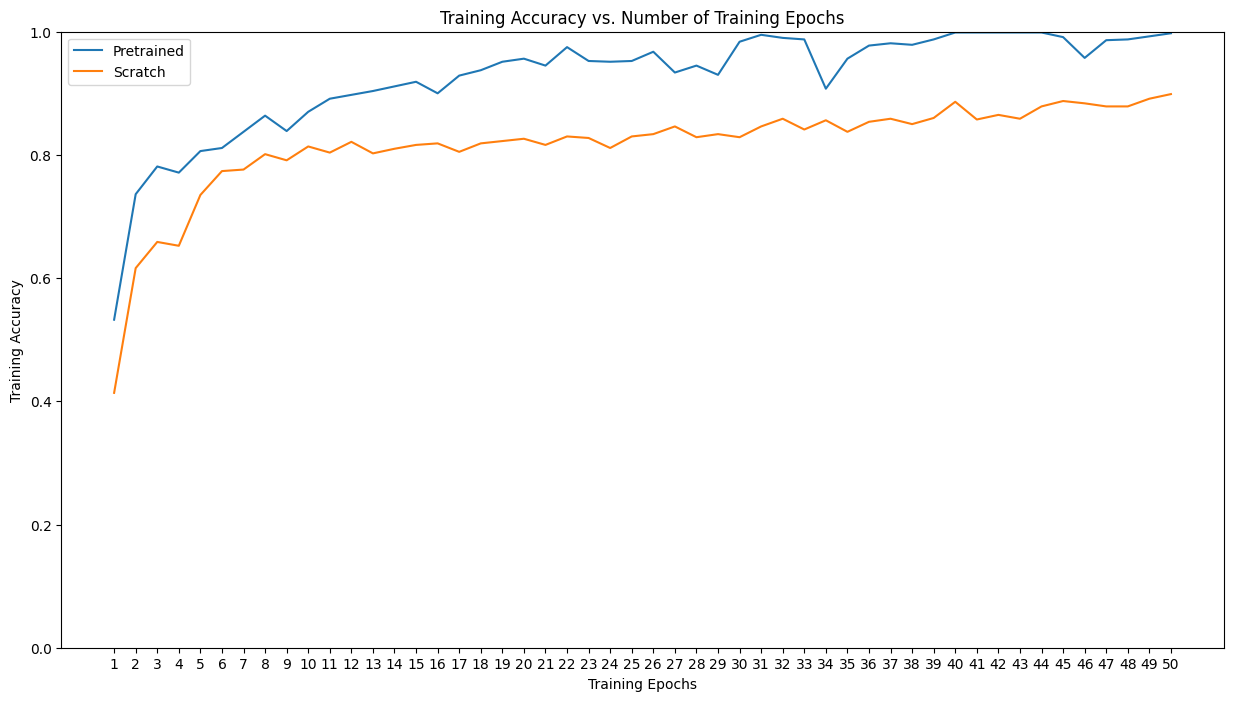

In [ ]:
plt.figure(figsize=(15, 8)) # Ajustar el tamaño de la figura
plt.title("Training Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Training Accuracy")
plt.plot(range(1,num_epochs+1),ohist_train_acc,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist_train_acc,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

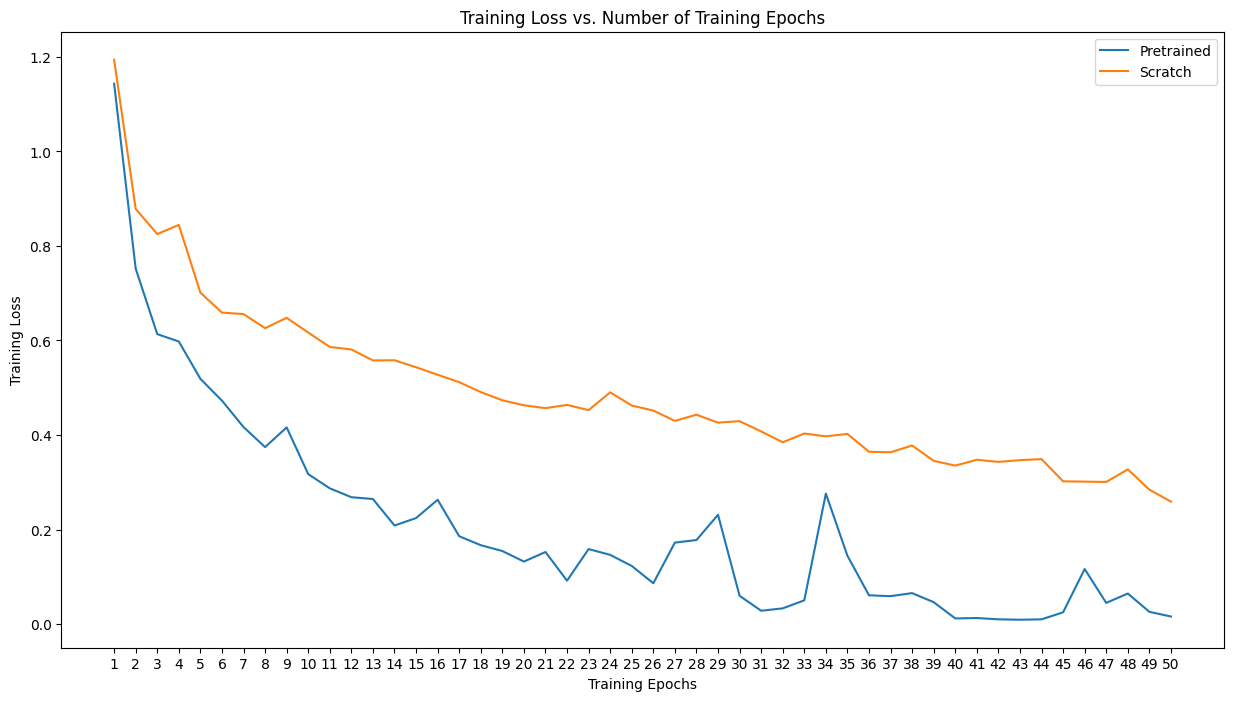

In [ ]:
plt.figure(figsize=(15, 8)) # Ajustar el tamaño de la figura
plt.title("Training Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Training Loss")
plt.plot(range(1,num_epochs+1),ohist_train_loss,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist_train_loss,label="Scratch")
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

## 5000

In [14]:
dataset_100 = torch.utils.data.Subset(dataset, range(5000)) # Para un primer intento, dataset de 100 imagenes 

# Definir tamaño de los conjuntos de entrenamiento y validación
train_size = int(0.8 * len(dataset_100))
val_size = len(dataset_100) - train_size

# Dividir el dataset en conjuntos de entrenamiento y validación de manera aleatoria
train_data, val_data = random_split(dataset_100, [train_size, val_size])

In [15]:
# Creamos un diccionario con los datasets de entrenamiento y validación
image_datasets = {'train': train_data, 'val': val_data}

# Creamos un diccionario con los dataloaders del diccionario image_datasets
batch_size = 8
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'val']}

In [ ]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist_val_acc, hist_val_loss, hist_train_acc, hist_train_loss = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/49
----------
train Loss: 0.7833 Acc: 0.7095
val Loss: 0.6332 Acc: 0.7990

Epoch 1/49
----------
train Loss: 0.5184 Acc: 0.8170
val Loss: 0.5010 Acc: 0.8090

Epoch 2/49
----------
train Loss: 0.4454 Acc: 0.8307
val Loss: 0.5279 Acc: 0.8070

Epoch 3/49
----------
train Loss: 0.4206 Acc: 0.8390
val Loss: 0.4909 Acc: 0.8030

Epoch 4/49
----------
train Loss: 0.4087 Acc: 0.8427
val Loss: 0.4712 Acc: 0.8290

Epoch 5/49
----------
train Loss: 0.3702 Acc: 0.8565
val Loss: 0.4362 Acc: 0.8390

Epoch 6/49
----------
train Loss: 0.3548 Acc: 0.8655
val Loss: 0.4798 Acc: 0.8230

Epoch 7/49
----------
train Loss: 0.3365 Acc: 0.8712
val Loss: 0.4613 Acc: 0.8360

Epoch 8/49
----------
train Loss: 0.3091 Acc: 0.8800
val Loss: 0.5831 Acc: 0.8470

Epoch 9/49
----------
train Loss: 0.3093 Acc: 0.8782
val Loss: 0.5207 Acc: 0.8360

Epoch 10/49
----------
train Loss: 0.2847 Acc: 0.8875
val Loss: 0.5064 Acc: 0.8320

Epoch 11/49
----------
train Loss: 0.2578 Acc: 0.8965
val Loss: 0.5970 Acc: 0.8480

Ep

In [ ]:
# Initialize the non-pretrained version of the model used for this run
scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_, scratch_hist_val_acc, scratch_hist_val_loss, scratch_hist_train_acc, scratch_hist_train_loss = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/49
----------
train Loss: 0.9885 Acc: 0.5232
val Loss: 0.7422 Acc: 0.6760

Epoch 1/49
----------
train Loss: 0.7247 Acc: 0.6977
val Loss: 0.5947 Acc: 0.7450

Epoch 2/49
----------
train Loss: 0.6408 Acc: 0.7343
val Loss: 0.5903 Acc: 0.7370

Epoch 3/49
----------
train Loss: 0.6276 Acc: 0.7350
val Loss: 0.5951 Acc: 0.7520

Epoch 4/49
----------
train Loss: 0.6103 Acc: 0.7422
val Loss: 0.6309 Acc: 0.7070

Epoch 5/49
----------
train Loss: 0.5977 Acc: 0.7438
val Loss: 0.5913 Acc: 0.7360

Epoch 6/49
----------
train Loss: 0.5707 Acc: 0.7485
val Loss: 0.5529 Acc: 0.7490

Epoch 7/49
----------
train Loss: 0.5702 Acc: 0.7498
val Loss: 0.6109 Acc: 0.7380

Epoch 8/49
----------
train Loss: 0.5569 Acc: 0.7500
val Loss: 0.5936 Acc: 0.7310

Epoch 9/49
----------
train Loss: 0.5471 Acc: 0.7582
val Loss: 0.5374 Acc: 0.7500

Epoch 10/49
----------
train Loss: 0.5322 Acc: 0.7590
val Loss: 0.5755 Acc: 0.7450

Epoch 11/49
----------
train Loss: 0.5241 Acc: 0.7660
val Loss: 0.5671 Acc: 0.7410

Ep

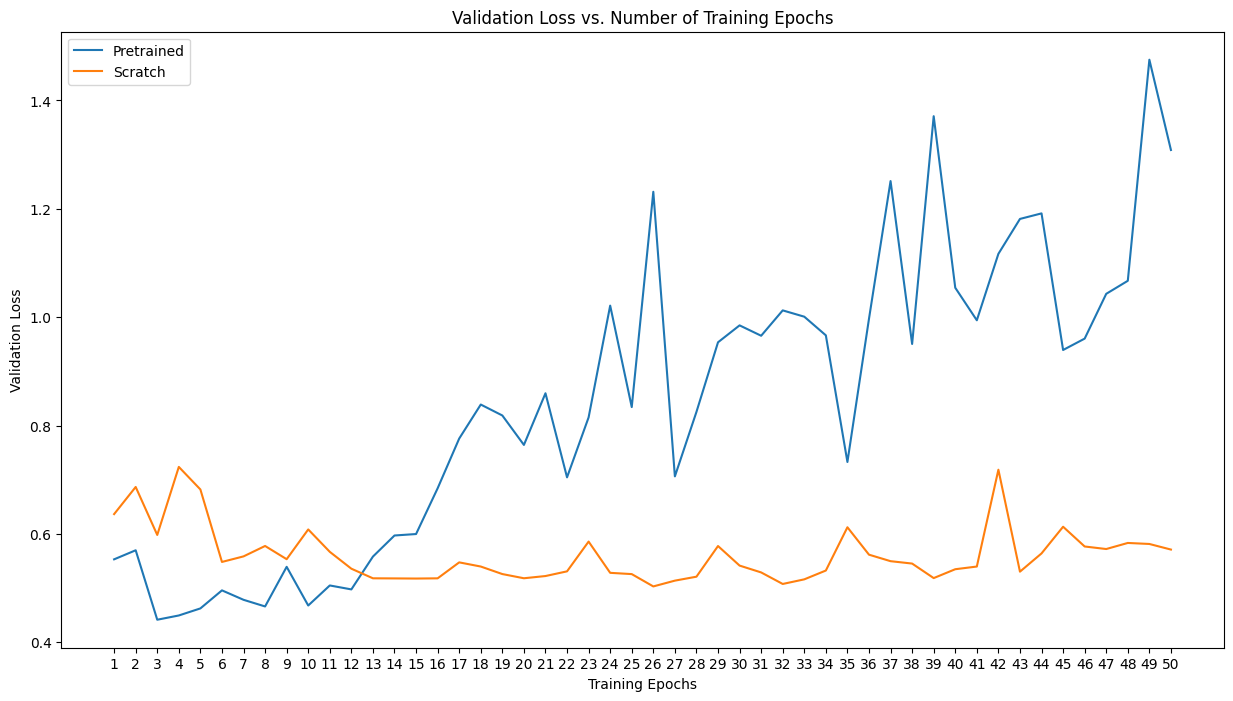

In [ ]:
ohist_val_loss = []
shist_val_loss = []

ohist_val_loss = [h for h in hist_val_loss]
shist_val_loss = [h for h in scratch_hist_val_loss]

plt.figure(figsize=(15, 8)) # Ajustar el tamaño de la figura
plt.title("Validation Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Loss")
plt.plot(range(1,num_epochs+1),ohist_val_loss,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist_val_loss,label="Scratch")
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

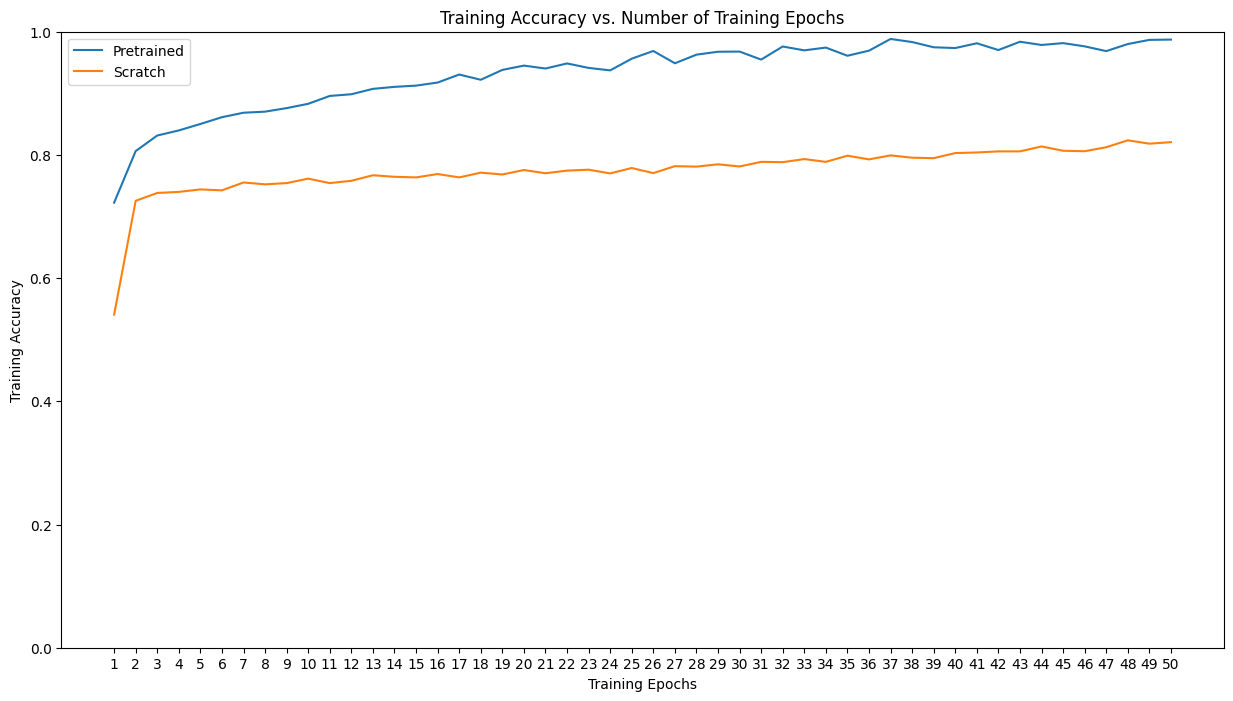

In [ ]:
ohist_train_acc = []
shist_train_acc = []

ohist_train_acc = [h.cpu().numpy() for h in hist_train_acc]
shist_train_acc = [h.cpu().numpy() for h in scratch_hist_train_acc]

plt.figure(figsize=(15, 8)) # Ajustar el tamaño de la figura
plt.title("Training Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Training Accuracy")
plt.plot(range(1,num_epochs+1),ohist_train_acc,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist_train_acc,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

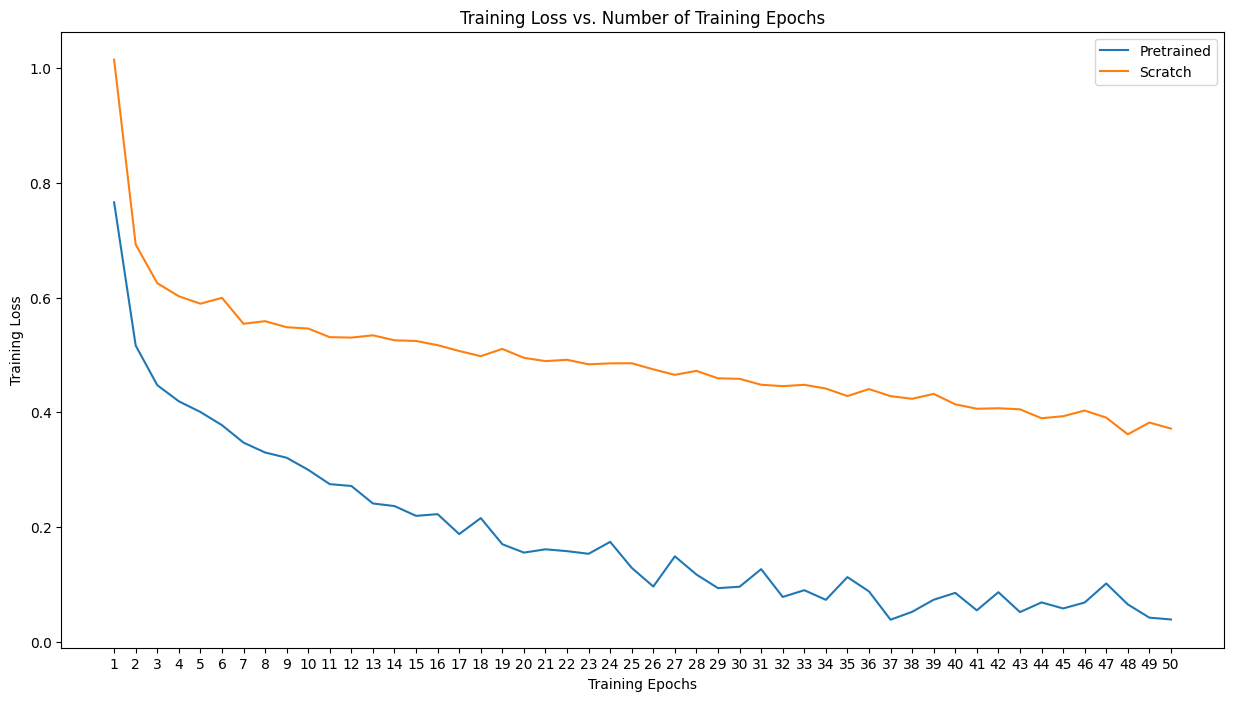

In [ ]:
ohist_train_loss = []
shist_train_loss = []

ohist_train_loss = [h for h in hist_train_loss]
shist_train_loss = [h for h in scratch_hist_train_loss]

plt.figure(figsize=(15, 8)) # Ajustar el tamaño de la figura
plt.title("Training Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Training Loss")
plt.plot(range(1,num_epochs+1),ohist_train_loss,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist_train_loss,label="Scratch")
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

## 10000

In [ ]:
dataset_100 = torch.utils.data.Subset(dataset, range(10000)) # Para un primer intento, dataset de 100 imagenes 

# Definir tamaño de los conjuntos de entrenamiento y validación
train_size = int(0.8 * len(dataset_100))
val_size = len(dataset_100) - train_size

# Dividir el dataset en conjuntos de entrenamiento y validación de manera aleatoria
train_data, val_data = random_split(dataset_100, [train_size, val_size])

In [ ]:
# Creamos un diccionario con los datasets de entrenamiento y validación
image_datasets = {'train': train_data, 'val': val_data}

# Creamos un diccionario con los dataloaders del diccionario image_datasets
batch_size = 8
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'val']}

In [ ]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist_val_acc, hist_val_loss, hist_train_acc, hist_train_loss = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/49
----------
train Loss: 0.6408 Acc: 0.7709
val Loss: 0.4904 Acc: 0.8160

Epoch 1/49
----------
train Loss: 0.4762 Acc: 0.8223
val Loss: 0.5138 Acc: 0.8250

Epoch 2/49
----------
train Loss: 0.4367 Acc: 0.8347
val Loss: 0.4530 Acc: 0.8150

Epoch 3/49
----------
train Loss: 0.4083 Acc: 0.8444
val Loss: 0.4553 Acc: 0.8260

Epoch 4/49
----------
train Loss: 0.3930 Acc: 0.8454
val Loss: 0.4849 Acc: 0.8210

Epoch 5/49
----------
train Loss: 0.3718 Acc: 0.8555
val Loss: 0.4380 Acc: 0.8260

Epoch 6/49
----------
train Loss: 0.3599 Acc: 0.8604
val Loss: 0.4265 Acc: 0.8395

Epoch 7/49
----------
train Loss: 0.3429 Acc: 0.8644
val Loss: 0.4390 Acc: 0.8330

Epoch 8/49
----------
train Loss: 0.3188 Acc: 0.8722
val Loss: 0.4875 Acc: 0.8305

Epoch 9/49
----------
train Loss: 0.3126 Acc: 0.8772
val Loss: 0.5444 Acc: 0.8250

Epoch 10/49
----------
train Loss: 0.3020 Acc: 0.8805
val Loss: 0.4511 Acc: 0.8290

Epoch 11/49
----------
train Loss: 0.2885 Acc: 0.8848
val Loss: 0.4981 Acc: 0.8345

Ep

In [ ]:
# Initialize the non-pretrained version of the model used for this run
scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_, scratch_hist_val_acc, scratch_hist_val_loss, scratch_hist_train_acc, scratch_hist_train_loss = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/49
----------


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


train Loss: 0.8068 Acc: 0.6695
val Loss: 0.5840 Acc: 0.8200

Epoch 1/49
----------
train Loss: 0.5863 Acc: 0.8020
val Loss: 0.5392 Acc: 0.7935

Epoch 2/49
----------
train Loss: 0.5088 Acc: 0.8103
val Loss: 0.4895 Acc: 0.8180

Epoch 3/49
----------
train Loss: 0.4878 Acc: 0.8166
val Loss: 0.4506 Acc: 0.8245

Epoch 4/49
----------
train Loss: 0.4644 Acc: 0.8263
val Loss: 0.4432 Acc: 0.8345

Epoch 5/49
----------
train Loss: 0.4655 Acc: 0.8184
val Loss: 0.4563 Acc: 0.8195

Epoch 6/49
----------
train Loss: 0.4596 Acc: 0.8243
val Loss: 0.4374 Acc: 0.8325

Epoch 7/49
----------
train Loss: 0.4375 Acc: 0.8310
val Loss: 0.4286 Acc: 0.8310

Epoch 8/49
----------
train Loss: 0.4275 Acc: 0.8349
val Loss: 0.4360 Acc: 0.8325

Epoch 9/49
----------
train Loss: 0.4282 Acc: 0.8325
val Loss: 0.4128 Acc: 0.8405

Epoch 10/49
----------
train Loss: 0.4193 Acc: 0.8363
val Loss: 0.4187 Acc: 0.8345

Epoch 11/49
----------
train Loss: 0.4137 Acc: 0.8389
val Loss: 0.4557 Acc: 0.8270

Epoch 12/49
----------
t

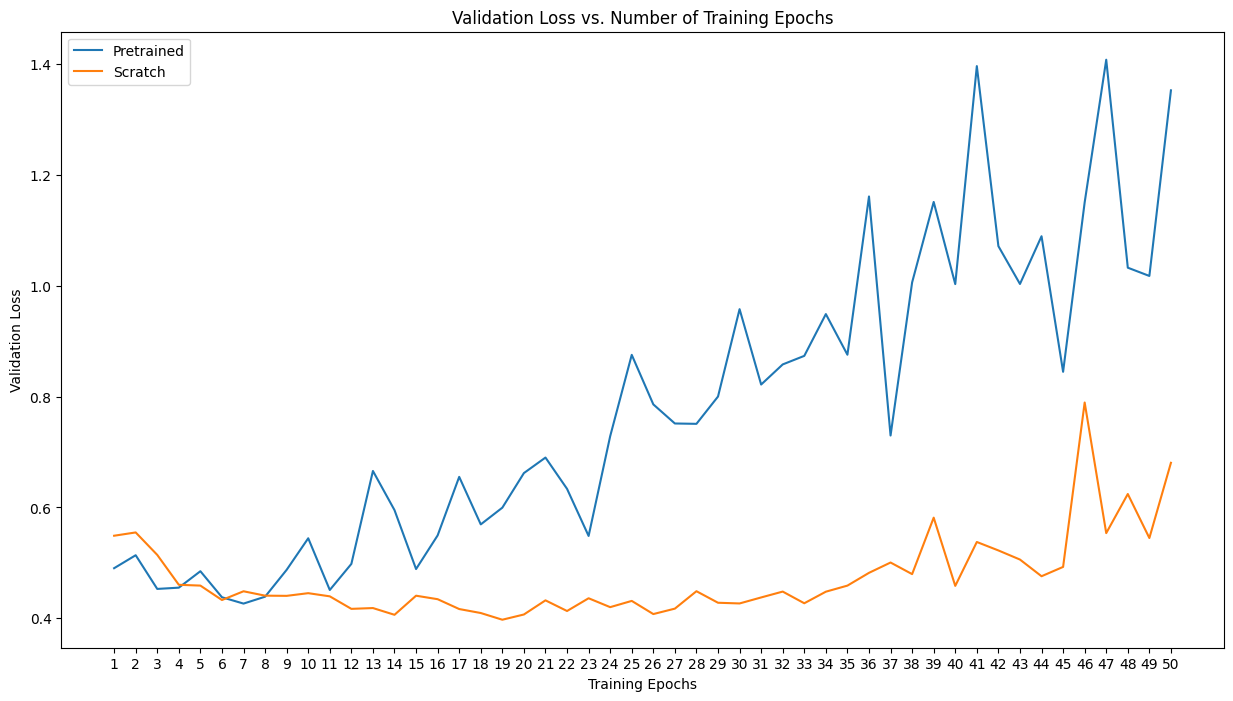

In [ ]:
ohist_val_loss = []
shist_val_loss = []

ohist_val_loss = [h for h in hist_val_loss]
shist_val_loss = [h for h in scratch_hist_val_loss]

plt.figure(figsize=(15, 8)) # Ajustar el tamaño de la figura
plt.title("Validation Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Loss")
plt.plot(range(1,num_epochs+1),ohist_val_loss,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist_val_loss,label="Scratch")
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

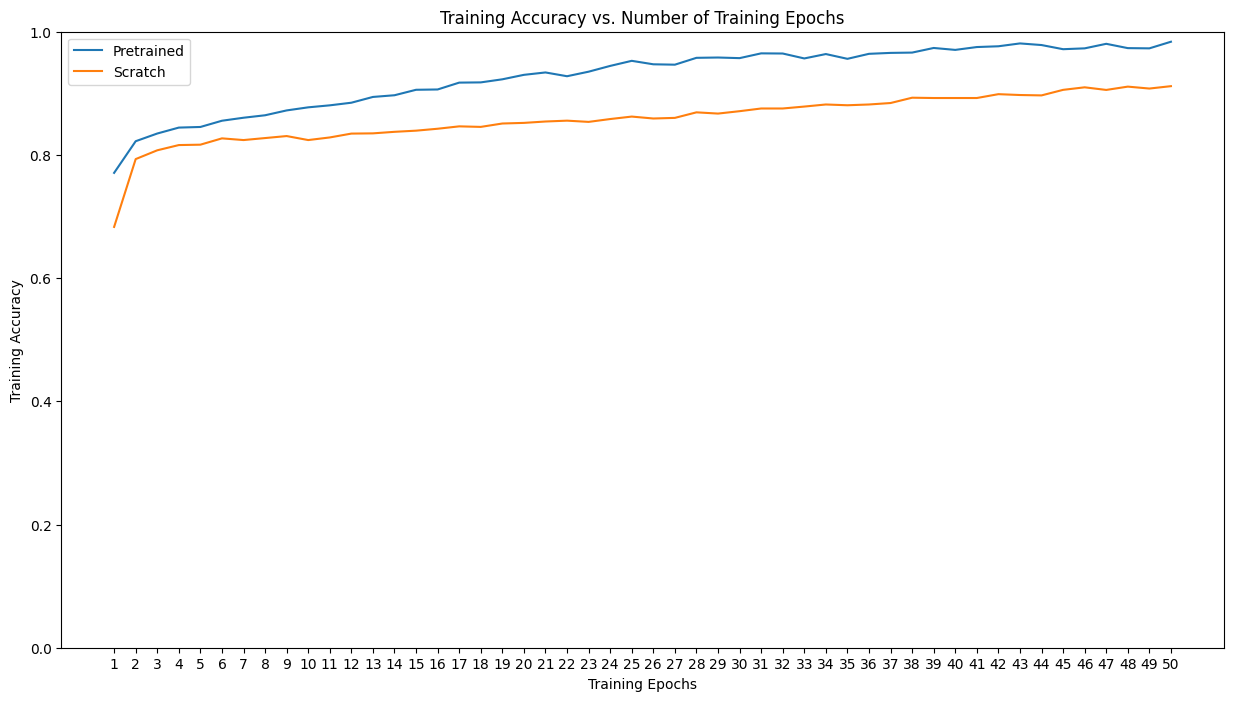

In [ ]:
ohist_train_acc = []
shist_train_acc = []

ohist_train_acc = [h.cpu().numpy() for h in hist_train_acc]
shist_train_acc = [h.cpu().numpy() for h in scratch_hist_train_acc]

plt.figure(figsize=(15, 8)) # Ajustar el tamaño de la figura
plt.title("Training Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Training Accuracy")
plt.plot(range(1,num_epochs+1),ohist_train_acc,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist_train_acc,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

<Figure size 1500x800 with 0 Axes>

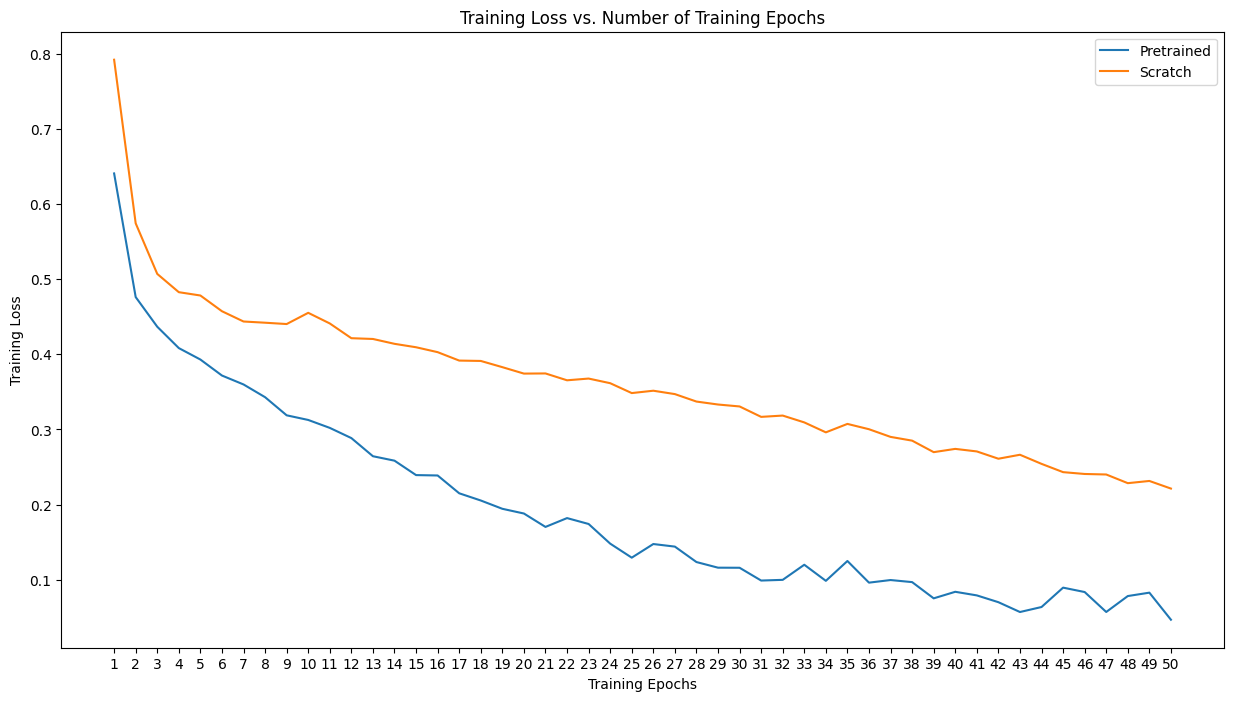

In [ ]:
ohist_train_loss = []
shist_train_loss = []

ohist_train_loss = [h for h in hist_train_loss]
shist_train_loss = [h for h in scratch_hist_train_loss]

plt.figure(figsize=(15, 8)) # Ajustar el tamaño de la figura
plt.figure(figsize=(15, 8)) # Ajustar el tamaño de la figura
plt.title("Training Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Training Loss")
plt.plot(range(1,num_epochs+1),ohist_train_loss,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist_train_loss,label="Scratch")
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

classes = ('Under', 'Over', 'Empty', 'OK')

y_pred_val = []
y_true_val = []
yscore_val = []

for inputs, labels in dataloaders_dict['val']:
        inputs, labels = inputs.to(device), labels.to(device)

        output = model_ft(inputs) # Feed Network
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred_val.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true_val.extend(labels) # Save Truth

        model_ft.eval()
        logits = model_ft(inputs)
        yscore = F.softmax(logits, dim=1).data.cpu().numpy() # assuming logits has the shape [batch_size, nb_classes]
        yscore_val.extend(yscore)

y_pred_val = np.array(y_pred_val)
y_true_val = np.array(y_true_val)
yscore_val = np.array(yscore_val)

In [ ]:
y_pred_train = []
y_true_train = []
yscore_train = []

for inputs, labels in dataloaders_dict['train']:
        inputs, labels = inputs.to(device), labels.to(device)

        output = model_ft(inputs) # Feed Network
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred_train.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true_train.extend(labels) # Save Truth

        model_ft.eval()
        logits = model_ft(inputs)
        yscore = F.softmax(logits, dim=1).data.cpu().numpy() # assuming logits has the shape [batch_size, nb_classes]
        yscore_train.extend(yscore)

y_pred_train = np.array(y_pred_train)
y_true_train = np.array(y_true_train)
yscore_train = np.array(yscore_train)

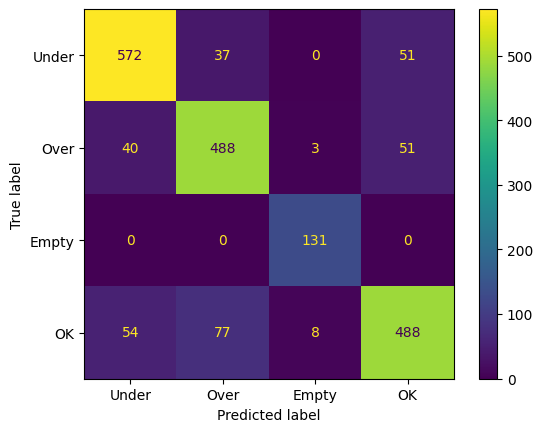

In [ ]:
# Build confusion matrix
cf_matrix = confusion_matrix(y_true_val, y_pred_val)
disp = ConfusionMatrixDisplay(confusion_matrix = cf_matrix, display_labels = classes)
disp.plot()
plt.show()


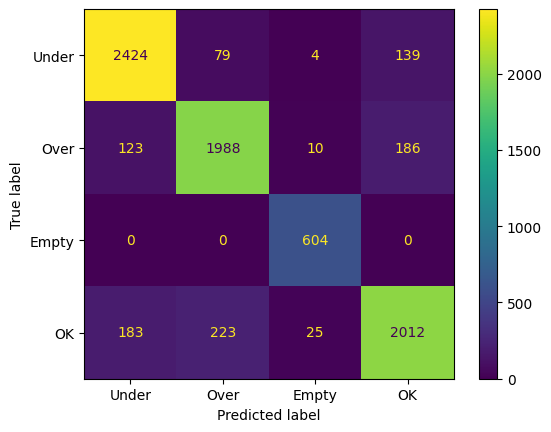

In [ ]:
# Build confusion matrix
cf_matrix = confusion_matrix(y_true_train, y_pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix = cf_matrix, display_labels = classes)
disp.plot()
plt.show()

## 15000

In [ ]:
dataset_15000 = torch.utils.data.Subset(dataset, range(15000)) # Para un primer intento, dataset de 100 imagenes 

# Definir tamaño de los conjuntos de entrenamiento y validación
train_size = int(0.8 * len(dataset_15000))
val_size = len(dataset_15000) - train_size

# Dividir el dataset en conjuntos de entrenamiento y validación de manera aleatoria
train_data, val_data = random_split(dataset_20000, [train_size, val_size])

In [ ]:
# Creamos un diccionario con los datasets de entrenamiento y validación
image_datasets = {'train': train_data, 'val': val_data}

# Creamos un diccionario con los dataloaders del diccionario image_datasets
batch_size = 8
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'val']}

In [ ]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist_val_acc, hist_val_loss, hist_train_acc, hist_train_loss = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/49
----------
train Loss: 0.6144 Acc: 0.7681
val Loss: 0.4593 Acc: 0.8190

Epoch 1/49
----------
train Loss: 0.4611 Acc: 0.8265
val Loss: 0.4419 Acc: 0.8427

Epoch 2/49
----------
train Loss: 0.4285 Acc: 0.8370
val Loss: 0.4005 Acc: 0.8383

Epoch 3/49
----------
train Loss: 0.4050 Acc: 0.8415
val Loss: 0.4038 Acc: 0.8480

Epoch 4/49
----------
train Loss: 0.3886 Acc: 0.8500
val Loss: 0.4021 Acc: 0.8493

Epoch 5/49
----------
train Loss: 0.3735 Acc: 0.8510
val Loss: 0.3910 Acc: 0.8463

Epoch 6/49
----------
train Loss: 0.3577 Acc: 0.8608
val Loss: 0.4014 Acc: 0.8380

Epoch 7/49
----------
train Loss: 0.3449 Acc: 0.8643
val Loss: 0.3943 Acc: 0.8467

Epoch 8/49
----------
train Loss: 0.3356 Acc: 0.8678
val Loss: 0.3765 Acc: 0.8503

Epoch 9/49
----------
train Loss: 0.3254 Acc: 0.8707
val Loss: 0.4484 Acc: 0.8240

Epoch 10/49
----------
train Loss: 0.3149 Acc: 0.8766
val Loss: 0.4318 Acc: 0.8380

Epoch 11/49
----------
train Loss: 0.2932 Acc: 0.8852
val Loss: 0.4458 Acc: 0.8420

Ep

In [ ]:
# Initialize the non-pretrained version of the model used for this run
scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_, scratch_hist_val_acc, scratch_hist_val_loss, scratch_hist_train_acc, scratch_hist_train_loss = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))

# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
ohist_val_acc = []
shist_val_acc = []

ohist_val_acc = [h.cpu().numpy() for h in hist_val_acc]
shist_val_acc = [h.cpu().numpy() for h in scratch_hist_val_acc]

plt.figure(figsize=(15, 8)) # Ajustar el tamaño de la figura
plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist_val_acc,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist_val_acc,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

Epoch 0/49
----------


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


train Loss: 0.7432 Acc: 0.6837
val Loss: 0.6754 Acc: 0.7680

Epoch 1/49
----------
train Loss: 0.5667 Acc: 0.7931
val Loss: 0.4644 Acc: 0.8240

Epoch 2/49
----------
train Loss: 0.5043 Acc: 0.8073
val Loss: 0.4516 Acc: 0.8230

Epoch 3/49
----------
train Loss: 0.4719 Acc: 0.8207
val Loss: 0.5039 Acc: 0.8027

Epoch 4/49
----------
train Loss: 0.4522 Acc: 0.8279
val Loss: 0.4353 Acc: 0.8373

Epoch 5/49
----------
train Loss: 0.4395 Acc: 0.8297
val Loss: 0.4120 Acc: 0.8427

Epoch 6/49
----------
train Loss: 0.4357 Acc: 0.8293
val Loss: 0.4730 Acc: 0.8227

Epoch 7/49
----------
train Loss: 0.4233 Acc: 0.8356
val Loss: 0.4298 Acc: 0.8470

Epoch 8/49
----------
train Loss: 0.4200 Acc: 0.8377
val Loss: 0.4388 Acc: 0.8313

Epoch 9/49
----------
train Loss: 0.4168 Acc: 0.8361
val Loss: 0.4044 Acc: 0.8390

Epoch 10/49
----------
train Loss: 0.4090 Acc: 0.8412
val Loss: 0.3915 Acc: 0.8470

Epoch 11/49
----------
train Loss: 0.4078 Acc: 0.8420
val Loss: 0.4055 Acc: 0.8497

Epoch 12/49
----------
t

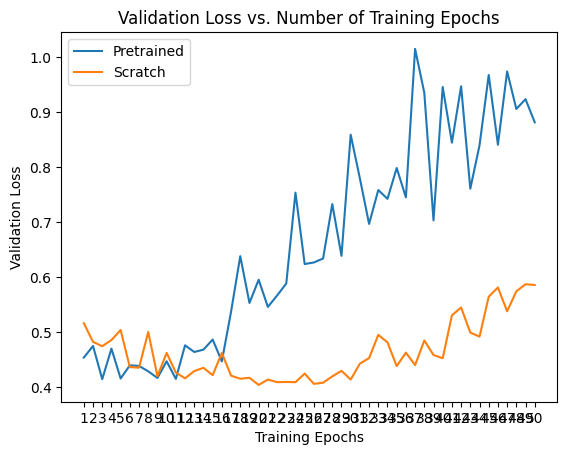

In [ ]:
ohist_val_loss = []
shist_val_loss = []

ohist_val_loss = [h for h in hist_val_loss]
shist_val_loss = [h for h in scratch_hist_val_loss]

plt.figure(figsize=(15, 8)) # Ajustar el tamaño de la figura
plt.title("Validation Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Loss")
plt.plot(range(1,num_epochs+1),ohist_val_loss,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist_val_loss,label="Scratch")
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

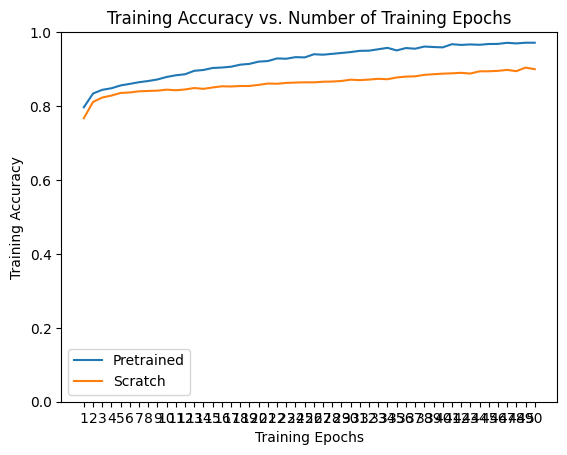

In [ ]:
ohist_train_acc = []
shist_train_acc = []

ohist_train_acc = [h.cpu().numpy() for h in hist_train_acc]
shist_train_acc = [h.cpu().numpy() for h in scratch_hist_train_acc]

plt.title("Training Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Training Accuracy")
plt.plot(range(1,num_epochs+1),ohist_train_acc,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist_train_acc,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

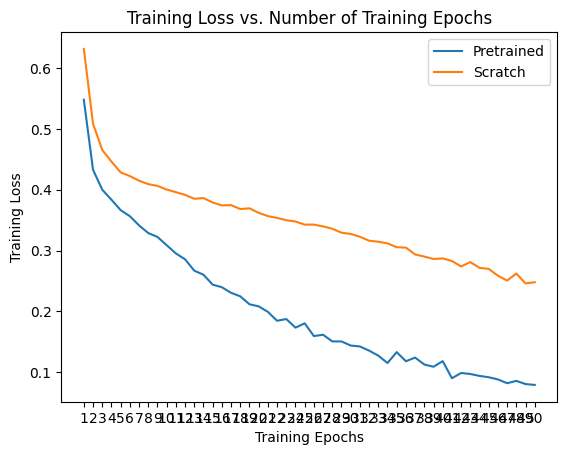

In [ ]:
ohist_train_loss = []
shist_train_loss = []

ohist_train_loss = [h for h in hist_train_loss]
shist_train_loss = [h for h in scratch_hist_train_loss]

plt.title("Training Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Training Loss")
plt.plot(range(1,num_epochs+1),ohist_train_loss,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist_train_loss,label="Scratch")
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

# Pruebo con otros modelos

## VGG

In [ ]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
#data_dir = "./content/drive/MyDrive/Dataset_hymenoptera/hymenoptera_data"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "vgg"

# Number of classes in the dataset
num_classes = 4

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for
num_epochs = 11

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False

In [ ]:
scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_, scratch_hist_val_acc, scratch_hist_val_loss, scratch_hist_train_acc, scratch_hist_train_loss = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))

# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
shist_val_acc = []
shist_train_acc = []

shist_val_acc = [h.cpu().numpy() for h in scratch_hist_val_acc]
shist_train_acc = [h.cpu().numpy() for h in scratch_hist_train_acc]

plt.title("Validation and Training Accuracy vs. Number of Training Epochs")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.plot(range(1,num_epochs+1),shist_val_acc,label="Validation")
plt.plot(range(1,num_epochs+1),shist_train_acc,label="Training")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 0/10
----------


RuntimeError: ignored

In [ ]:
shist_val_loss = []
shist_train_loss = []

shist_val_loss = [h for h in scratch_hist_val_loss]
shist_train_loss = [h for h in scratch_hist_train_loss]

plt.title("Validation and Training Loss vs. Number of Training Epochs")
plt.xlabel("Number of Epochs")
plt.ylabel("Training Loss")
plt.plot(range(1,num_epochs+1),shist_val_loss,label="Validation")
plt.plot(range(1,num_epochs+1),shist_train_loss,label="Training")
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

## Alexnet

In [ ]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
#data_dir = "./content/drive/MyDrive/Dataset_hymenoptera/hymenoptera_data"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "alexnet"

# Number of classes in the dataset
num_classes = 4

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for
num_epochs = 11

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False

## Resnet

In [ ]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
#data_dir = "./content/drive/MyDrive/Dataset_hymenoptera/hymenoptera_data"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

# Number of classes in the dataset
num_classes = 4

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for
num_epochs = 11

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False

## Densenet

In [ ]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
#data_dir = "./content/drive/MyDrive/Dataset_hymenoptera/hymenoptera_data"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "densenet"

# Number of classes in the dataset
num_classes = 4

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for
num_epochs = 11

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False

## Inception

In [ ]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
#data_dir = "./content/drive/MyDrive/Dataset_hymenoptera/hymenoptera_data"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "inception"

# Number of classes in the dataset
num_classes = 4

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for
num_epochs = 11

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False

## Calculos

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []
    val_loss_history = []
    train_acc_history = []
    train_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history,val_loss_history,train_acc_history,train_loss_history

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth
100%|██████████| 507M/507M [00:02<00:00, 184MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [ ]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 features.0.weight
	 features.0.bias
	 features.1.weight
	 features.1.bias
	 features.4.weight
	 features.4.bias
	 features.5.weight
	 features.5.bias
	 features.8.weight
	 features.8.bias
	 features.9.weight
	 features.9.bias
	 features.11.weight
	 features.11.bias
	 features.12.weight
	 features.12.bias
	 features.15.weight
	 features.15.bias
	 features.16.weight
	 features.16.bias
	 features.18.weight
	 features.18.bias
	 features.19.weight
	 features.19.bias
	 features.22.weight
	 features.22.bias
	 features.23.weight
	 features.23.bias
	 features.25.weight
	 features.25.bias
	 features.26.weight
	 features.26.bias
	 classifier.0.weight
	 classifier.0.bias
	 classifier.3.weight
	 classifier.3.bias
	 classifier.6.weight
	 classifier.6.bias


In [ ]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist_val_acc, hist_val_loss, hist_train_acc, hist_train_loss = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/3
----------


KeyboardInterrupt: ignored

In [ ]:
train_acc = []
val_acc = []

val_acc = [h.cpu().numpy() for h in hist_val_acc]
train_acc = [h.cpu().numpy() for h in hist_train_acc]

plt.title("Validation and Training Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy")
plt.plot(range(1,num_epochs+1),val_acc,label="Validation")
plt.plot(range(1,num_epochs+1),train_acc,label="Training")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [ ]:
val_loss = []
train_loss = []

val_loss = [h for h in hist_val_loss]
train_loss = [h for h in hist_train_loss]

plt.title("Validation and Training Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
plt.plot(range(1,num_epochs+1),val_loss,label="Validation")
plt.plot(range(1,num_epochs+1),train_loss,label="Training")
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

# Aumentacion de datos

# Hiperparámetros

# Nueva sección